In [1]:
import time
import math
import numpy as np
import pandas as pd
import baostock as bs
import tushare as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# 计算个股偏度指标

## 导入日度股票交易数据

In [19]:
# 日度股票交易数据包括个股日度收益率、成交量、换手率、总市值、PE、PB等
# 样本区间## 导入日度股票交易数据为2000年1月到2020年9月，数据来自tushare
stk = pd.read_csv('../stk_daily.csv')
stk['month'] = stk['trade_date'].apply(lambda x:int(str(x)[0:6]))
stk = stk[stk['trade_date']<20200900].reset_index(drop=True)

## 下载市场指数日序列

In [2]:
# 市场指数采用上证指数，数据来自tushare
token = '604c146e2dc9044b250b3312916ef9e170734e53b0528384ccb736b7'
pro = ts.pro_api(token)
index = pro.index_daily(ts_code='000001.SH')
index['trade_date'] = index['trade_date'].astype(int)
index['pct_chg'] = index['pct_chg']/100
index = index[index['trade_date']>20000001].sort_values(by='trade_date').reset_index(drop=True)

## 导入无风险利率

In [5]:
# 无风险利率采用7日银行间质押式回购利率，数据来自万得金融终端
rf = pd.read_excel('../银行间质押式回购.xls')
rf = rf.iloc[0:-2,:].reset_index(drop=True)
rf['R007'] = (rf['R007']/100)/365
rf = rf.rename(columns={'指标名称':'trade_date'})
rf['trade_date'] = pd.to_datetime(rf['trade_date']).dt.strftime('%Y%m%d').astype(int)
rf['month'] = rf['trade_date'].apply(lambda x:str(x)[0:6]).astype(int)

## 合并数据

In [239]:
reg_data = pd.merge(stk,index[['trade_date','pct_chg']])[['trade_date','month','ts_code','ret','pct_chg']].rename(columns={'pct_chg':'index_ret'})
reg_data = pd.merge(reg_data,rf).dropna().reset_index(drop=True)

## 循环计算个股月度总偏度、协偏度、最大日收益

In [240]:
def cal_skew(data_i_t):
    skew = data_i_t['ret'].skew()
    #kurt = data_i_t['ret'].kurt()
    return skew
def cal_coskew(data_i_t):
    # Referrence: Ang et al.(2006) Downside Risks. JF
    r_i = data_i_t['ret'] - data_i_t['R007']
    r_m = data_i_t['index_ret'] - data_i_t['R007']
    res_i = r_i - r_i.mean()
    res_m = r_m - r_m.mean()
    coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
    #cokurt = (res_i*np.power(res_m,3)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(np.power(res_m,2).mean(),3/2))
    return coskew
def cal_iskew(data_i_t):
    r_i = data_i_t['ret'] - data_i_t['R007']
    r_m = data_i_t['index_ret'] - data_i_t['R007']
    res_i = sm.OLS(r_i,sm.add_constant(r_m)).fit().resid
    iskew = res_i.skew()
    return iskew
def cal_3d_MaxRet(data_i_t):
    return data_i_t['ret'].nlargest(3).mean()
def cal_5d_MaxRet(data_i_t):
    return data_i_t['ret'].nlargest(5).mean()
def cal_7d_MaxRet(data_i_t):
    return data_i_t['ret'].nlargest(7).mean()

In [242]:
total = []
for code,data_i in reg_data.groupby('ts_code'):
    factor_list = []
    for month,data_i_t in data_i.groupby('month'):
        skew = cal_skew(data_i_t)
        iskew = cal_iskew(data_i_t)
        coskew = cal_coskew(data_i_t)
        Max3d = cal_3d_MaxRet(data_i_t)
        Max5d = cal_5d_MaxRet(data_i_t)
        Max7d = cal_7d_MaxRet(data_i_t)
        dic = {
            'month':month,
            'skew':skew,
            'iskew':iskew,
            'coskew':coskew,
            'Max3d':Max3d,
            'Max5d':Max5d,
            'Max7d':Max7d
        }
        factor_list.append(dic)
    factor_df = pd.DataFrame(factor_list)
    factor_df['code'] = code
    total.append(factor_df)
    print(code)

000001.SZ
000002.SZ
000003.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000004.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000005.SZ
000006.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000007.SZ
000008.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000009.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000010.SZ
000011.SZ
000012.SZ
000013.SZ
000014.SZ
000015.SZ
000016.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000017.SZ
000018.SZ
000019.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000020.SZ
000021.SZ
000022.SZ
000023.SZ
000024.SZ
000025.SZ
000026.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000027.SZ
000028.SZ
000029.SZ
000030.SZ
000031.SZ
000032.SZ
000033.SZ
000034.SZ
000035.SZ
000036.SZ
000037.SZ
000038.SZ
000039.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000040.SZ
000042.SZ
000043.SZ
000045.SZ
000046.SZ
000047.SZ
000048.SZ
000049.SZ
000050.SZ
000055.SZ
000056.SZ
000058.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000059.SZ
000060.SZ
000061.SZ
000062.SZ
000063.SZ
000065.SZ
000066.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000068.SZ
000069.SZ
000070.SZ
000078.SZ
000088.SZ
000089.SZ
000090.SZ
000096.SZ
000099.SZ
000100.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000150.SZ
000151.SZ
000153.SZ
000155.SZ
000156.SZ
000157.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000158.SZ
000159.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000166.SZ
000301.SZ
000333.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000338.SZ
000400.SZ
000401.SZ
000402.SZ
000403.SZ
000404.SZ
000405.SZ
000406.SZ
000407.SZ
000408.SZ
000409.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000410.SZ
000411.SZ
000412.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000413.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000415.SZ
000416.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000417.SZ
000418.SZ
000419.SZ
000420.SZ
000421.SZ
000422.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000423.SZ
000425.SZ
000426.SZ
000428.SZ
000429.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000430.SZ
000488.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000498.SZ
000501.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000502.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000503.SZ
000504.SZ
000505.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000506.SZ
000507.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000509.SZ
000510.SZ
000511.SZ
000513.SZ
000514.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000515.SZ
000516.SZ
000517.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000518.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000519.SZ
000520.SZ
000521.SZ
000522.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000523.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000524.SZ
000525.SZ
000526.SZ
000527.SZ
000528.SZ
000529.SZ
000530.SZ
000531.SZ
000532.SZ
000533.SZ
000534.SZ
000535.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000536.SZ
000537.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000538.SZ
000539.SZ
000540.SZ
000541.SZ
000542.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000543.SZ
000544.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000545.SZ
000546.SZ
000547.SZ
000548.SZ
000549.SZ
000550.SZ
000551.SZ
000552.SZ
000553.SZ
000554.SZ
000555.SZ
000556.SZ
000557.SZ
000558.SZ
000559.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000560.SZ
000561.SZ
000562.SZ
000563.SZ
000564.SZ
000565.SZ
000566.SZ
000567.SZ
000568.SZ
000569.SZ
000570.SZ
000571.SZ
000572.SZ
000573.SZ
000576.SZ
000578.SZ
000581.SZ
000582.SZ
000583.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000584.SZ
000585.SZ
000586.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000587.SZ
000588.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000589.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000590.SZ
000591.SZ
000592.SZ
000593.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000594.SZ
000595.SZ
000596.SZ
000597.SZ
000598.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000599.SZ
000600.SZ
000601.SZ
000602.SZ
000603.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000605.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000606.SZ
000607.SZ
000608.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000609.SZ
000610.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000611.SZ
000612.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000613.SZ
000615.SZ
000616.SZ
000617.SZ
000618.SZ
000619.SZ
000620.SZ
000621.SZ
000622.SZ
000623.SZ
000625.SZ
000626.SZ
000627.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000628.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000629.SZ
000630.SZ
000631.SZ
000632.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000633.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000635.SZ
000636.SZ
000637.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000638.SZ
000639.SZ
000650.SZ
000651.SZ
000652.SZ
000653.SZ
000655.SZ
000656.SZ
000657.SZ
000658.SZ
000659.SZ
000660.SZ
000661.SZ
000662.SZ
000663.SZ
000665.SZ
000666.SZ
000667.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000668.SZ
000669.SZ
000670.SZ
000671.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000672.SZ
000673.SZ
000675.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000676.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000677.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000678.SZ
000679.SZ
000680.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000681.SZ
000682.SZ
000683.SZ
000685.SZ
000686.SZ
000687.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000688.SZ
000689.SZ
000690.SZ
000691.SZ
000692.SZ
000693.SZ
000695.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000697.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000698.SZ
000699.SZ
000700.SZ
000701.SZ
000702.SZ
000703.SZ
000705.SZ
000707.SZ
000708.SZ
000709.SZ
000710.SZ
000711.SZ
000712.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000713.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000715.SZ
000716.SZ
000717.SZ
000718.SZ
000719.SZ
000720.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000721.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000722.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000723.SZ
000725.SZ
000726.SZ
000727.SZ
000728.SZ
000729.SZ
000730.SZ
000731.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000732.SZ
000733.SZ
000735.SZ
000736.SZ
000737.SZ
000738.SZ
000739.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000748.SZ
000750.SZ
000751.SZ
000752.SZ
000753.SZ
000755.SZ
000756.SZ
000757.SZ
000758.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000759.SZ
000760.SZ
000761.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000762.SZ
000763.SZ
000765.SZ
000766.SZ
000767.SZ
000768.SZ
000769.SZ
000776.SZ
000777.SZ
000778.SZ
000779.SZ
000780.SZ
000782.SZ
000783.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000785.SZ
000786.SZ
000787.SZ
000788.SZ
000789.SZ
000790.SZ
000791.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000792.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000793.SZ
000795.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000796.SZ
000797.SZ
000798.SZ
000799.SZ
000800.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000801.SZ
000802.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000803.SZ
000805.SZ
000806.SZ
000807.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000809.SZ
000810.SZ
000811.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000812.SZ
000813.SZ
000815.SZ
000816.SZ
000817.SZ
000818.SZ
000819.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000820.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000821.SZ
000822.SZ
000823.SZ
000825.SZ
000826.SZ
000827.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000828.SZ
000829.SZ
000830.SZ
000831.SZ
000832.SZ
000833.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000835.SZ
000836.SZ
000837.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000838.SZ
000839.SZ
000848.SZ
000850.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000851.SZ
000852.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000856.SZ
000858.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000859.SZ
000860.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000861.SZ
000862.SZ
000863.SZ
000866.SZ
000868.SZ
000869.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000875.SZ
000876.SZ
000877.SZ
000878.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000880.SZ
000881.SZ
000882.SZ
000883.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000885.SZ
000886.SZ
000887.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000888.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000889.SZ
000890.SZ
000892.SZ
000893.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000895.SZ
000897.SZ
000898.SZ
000899.SZ
000900.SZ
000901.SZ
000902.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000903.SZ
000905.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000906.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000908.SZ
000909.SZ
000910.SZ
000911.SZ
000912.SZ
000913.SZ
000915.SZ
000916.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000917.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000918.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000919.SZ
000920.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000921.SZ
000922.SZ
000923.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000925.SZ
000926.SZ
000927.SZ
000928.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000929.SZ
000930.SZ
000931.SZ
000932.SZ
000933.SZ
000935.SZ
000936.SZ
000937.SZ
000938.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000939.SZ
000948.SZ
000949.SZ
000950.SZ
000951.SZ
000952.SZ
000953.SZ
000955.SZ
000956.SZ
000957.SZ
000958.SZ
000959.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000960.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000961.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000962.SZ
000963.SZ
000965.SZ
000966.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000967.SZ
000968.SZ
000969.SZ
000970.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000971.SZ
000972.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000973.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000975.SZ
000976.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000977.SZ
000978.SZ
000979.SZ
000980.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000981.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000982.SZ
000983.SZ
000985.SZ
000987.SZ
000988.SZ
000989.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000990.SZ
000993.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000995.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000996.SZ
000997.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


000998.SZ
000999.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


001696.SZ
001872.SZ
001896.SZ
001914.SZ
001965.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


001979.SZ
002001.SZ
002002.SZ
002003.SZ
002004.SZ
002005.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002006.SZ
002007.SZ
002008.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002009.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002010.SZ
002011.SZ
002012.SZ
002013.SZ
002014.SZ
002015.SZ
002016.SZ
002017.SZ
002018.SZ
002019.SZ
002020.SZ
002021.SZ
002022.SZ
002023.SZ
002024.SZ
002025.SZ
002026.SZ
002027.SZ
002028.SZ
002029.SZ
002030.SZ
002031.SZ
002032.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002033.SZ
002034.SZ
002035.SZ
002036.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002037.SZ
002038.SZ
002039.SZ
002040.SZ
002041.SZ
002042.SZ
002043.SZ
002044.SZ
002045.SZ
002046.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002047.SZ
002048.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002049.SZ
002050.SZ
002051.SZ
002052.SZ
002053.SZ
002054.SZ
002055.SZ
002056.SZ
002057.SZ
002058.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002059.SZ
002060.SZ
002061.SZ
002062.SZ
002063.SZ
002064.SZ
002065.SZ
002066.SZ
002067.SZ
002068.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002069.SZ
002070.SZ
002071.SZ
002072.SZ
002073.SZ
002074.SZ
002075.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002076.SZ
002077.SZ
002078.SZ
002079.SZ
002080.SZ
002081.SZ
002082.SZ
002083.SZ
002084.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002085.SZ
002086.SZ
002087.SZ
002088.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002089.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002090.SZ
002091.SZ
002092.SZ
002093.SZ
002094.SZ
002095.SZ
002096.SZ
002097.SZ
002098.SZ
002099.SZ
002100.SZ
002101.SZ
002102.SZ
002103.SZ
002104.SZ
002105.SZ
002106.SZ
002107.SZ
002108.SZ
002109.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002110.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002111.SZ
002112.SZ
002113.SZ
002114.SZ
002115.SZ
002116.SZ
002117.SZ
002118.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002119.SZ
002120.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002121.SZ
002122.SZ
002123.SZ
002124.SZ
002125.SZ
002126.SZ
002127.SZ
002128.SZ
002129.SZ
002130.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002131.SZ
002132.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002133.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002134.SZ
002135.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002136.SZ
002137.SZ
002138.SZ
002139.SZ
002140.SZ
002141.SZ
002142.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002143.SZ
002144.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002145.SZ
002146.SZ
002147.SZ
002148.SZ
002149.SZ
002150.SZ
002151.SZ
002152.SZ
002153.SZ
002154.SZ
002155.SZ
002156.SZ
002157.SZ
002158.SZ
002159.SZ
002160.SZ
002161.SZ
002162.SZ
002163.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002164.SZ
002165.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002166.SZ
002167.SZ
002168.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002169.SZ
002170.SZ
002171.SZ
002172.SZ
002173.SZ
002174.SZ
002175.SZ
002176.SZ
002177.SZ
002178.SZ
002179.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002180.SZ
002181.SZ
002182.SZ
002183.SZ
002184.SZ
002185.SZ
002186.SZ
002187.SZ
002188.SZ
002189.SZ
002190.SZ
002191.SZ
002192.SZ
002193.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002194.SZ
002195.SZ
002196.SZ
002197.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002198.SZ
002199.SZ
002200.SZ
002201.SZ
002202.SZ
002203.SZ
002204.SZ
002205.SZ
002206.SZ
002207.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002208.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002209.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002210.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002211.SZ
002212.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002213.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002214.SZ
002215.SZ
002216.SZ
002217.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002218.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002219.SZ
002220.SZ
002221.SZ
002222.SZ
002223.SZ
002224.SZ
002225.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002226.SZ
002227.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002228.SZ
002229.SZ
002230.SZ
002231.SZ
002232.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002233.SZ
002234.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002235.SZ
002236.SZ
002237.SZ
002238.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002239.SZ
002240.SZ
002241.SZ
002242.SZ
002243.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002244.SZ
002245.SZ
002246.SZ
002247.SZ
002248.SZ
002249.SZ
002250.SZ
002251.SZ
002252.SZ
002253.SZ
002254.SZ
002255.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002256.SZ
002258.SZ
002259.SZ
002260.SZ
002261.SZ
002262.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002263.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002264.SZ
002265.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002266.SZ
002267.SZ
002268.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002269.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002270.SZ
002271.SZ
002272.SZ
002273.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002274.SZ
002275.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002276.SZ
002277.SZ
002278.SZ
002279.SZ
002280.SZ
002281.SZ
002282.SZ
002283.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002284.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002285.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002286.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002287.SZ
002288.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002289.SZ
002290.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002291.SZ
002292.SZ
002293.SZ
002294.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002295.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002296.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002297.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002298.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002299.SZ
002300.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002301.SZ
002302.SZ
002303.SZ
002304.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002305.SZ
002306.SZ
002307.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002308.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002309.SZ
002310.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002311.SZ
002312.SZ
002313.SZ
002314.SZ
002315.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002316.SZ
002317.SZ
002318.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002319.SZ
002320.SZ
002321.SZ
002322.SZ
002323.SZ
002324.SZ
002325.SZ
002326.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002327.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002328.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002329.SZ
002330.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002331.SZ
002332.SZ
002333.SZ
002334.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002335.SZ
002336.SZ
002337.SZ
002338.SZ
002339.SZ
002340.SZ
002341.SZ
002342.SZ
002343.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002344.SZ
002345.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002346.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002347.SZ
002348.SZ
002349.SZ
002350.SZ
002351.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002352.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002353.SZ
002354.SZ
002355.SZ
002356.SZ
002357.SZ
002358.SZ
002359.SZ
002360.SZ
002361.SZ
002362.SZ
002363.SZ
002364.SZ
002365.SZ
002366.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002367.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002368.SZ
002369.SZ
002370.SZ
002371.SZ
002372.SZ
002373.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002374.SZ
002375.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002376.SZ
002377.SZ
002378.SZ
002379.SZ
002380.SZ
002381.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002382.SZ
002383.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002384.SZ
002385.SZ
002386.SZ
002387.SZ
002388.SZ
002389.SZ
002390.SZ
002391.SZ
002392.SZ
002393.SZ
002394.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002395.SZ
002396.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002397.SZ
002398.SZ
002399.SZ
002400.SZ
002401.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002402.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002403.SZ
002404.SZ
002405.SZ
002406.SZ
002407.SZ
002408.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002409.SZ
002410.SZ
002411.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002412.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002413.SZ
002414.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002415.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002416.SZ
002417.SZ
002418.SZ
002419.SZ
002420.SZ
002421.SZ
002422.SZ
002423.SZ
002424.SZ
002425.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002426.SZ
002427.SZ
002428.SZ
002429.SZ
002430.SZ
002431.SZ
002432.SZ
002433.SZ
002434.SZ
002435.SZ
002436.SZ
002437.SZ
002438.SZ
002439.SZ
002440.SZ
002441.SZ
002442.SZ
002443.SZ
002444.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002445.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002446.SZ
002447.SZ
002448.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002449.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002450.SZ
002451.SZ
002452.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002453.SZ
002454.SZ
002455.SZ
002456.SZ
002457.SZ
002458.SZ
002459.SZ
002460.SZ
002461.SZ
002462.SZ
002463.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002464.SZ
002465.SZ
002466.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002467.SZ
002468.SZ
002469.SZ
002470.SZ
002471.SZ
002472.SZ
002473.SZ
002474.SZ
002475.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002476.SZ
002477.SZ
002478.SZ
002479.SZ
002480.SZ
002481.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002482.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002483.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002484.SZ
002485.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002486.SZ
002487.SZ
002488.SZ
002489.SZ
002490.SZ
002491.SZ
002492.SZ
002493.SZ
002494.SZ
002495.SZ
002496.SZ
002497.SZ
002498.SZ
002499.SZ
002500.SZ
002501.SZ
002502.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002503.SZ
002504.SZ
002505.SZ
002506.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002507.SZ
002508.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002509.SZ
002510.SZ
002511.SZ
002512.SZ
002513.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002514.SZ
002515.SZ
002516.SZ
002517.SZ
002518.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002519.SZ
002520.SZ
002521.SZ
002522.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002523.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002524.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002526.SZ
002527.SZ
002528.SZ
002529.SZ
002530.SZ
002531.SZ
002532.SZ
002533.SZ
002534.SZ
002535.SZ
002536.SZ
002537.SZ
002538.SZ
002539.SZ
002540.SZ
002541.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002542.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002543.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002544.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002545.SZ
002546.SZ
002547.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002548.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002549.SZ
002550.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002551.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002552.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002553.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002554.SZ
002555.SZ
002556.SZ
002557.SZ
002558.SZ
002559.SZ
002560.SZ
002561.SZ
002562.SZ
002563.SZ
002564.SZ
002565.SZ
002566.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002567.SZ
002568.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002569.SZ
002570.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002571.SZ
002572.SZ
002573.SZ
002574.SZ
002575.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002576.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002577.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002578.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002579.SZ
002580.SZ
002581.SZ
002582.SZ
002583.SZ
002584.SZ
002585.SZ
002586.SZ
002587.SZ
002588.SZ
002589.SZ
002590.SZ
002591.SZ
002592.SZ
002593.SZ
002594.SZ
002595.SZ
002596.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002597.SZ
002598.SZ
002599.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002600.SZ
002601.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002602.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002603.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002604.SZ
002605.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002606.SZ
002607.SZ
002608.SZ
002609.SZ
002610.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002611.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002612.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002613.SZ
002614.SZ
002615.SZ
002616.SZ
002617.SZ
002618.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002619.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002620.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002621.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002622.SZ
002623.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002624.SZ
002625.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002626.SZ
002627.SZ
002628.SZ
002629.SZ
002630.SZ
002631.SZ
002632.SZ
002633.SZ
002634.SZ
002635.SZ
002636.SZ
002637.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002638.SZ
002639.SZ
002640.SZ
002641.SZ
002642.SZ
002643.SZ
002644.SZ
002645.SZ
002646.SZ
002647.SZ
002648.SZ
002649.SZ
002650.SZ
002651.SZ
002652.SZ
002653.SZ
002654.SZ
002655.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.pow

002656.SZ
002657.SZ
002658.SZ
002659.SZ
002660.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002661.SZ
002662.SZ
002663.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002664.SZ
002665.SZ
002666.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002667.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002668.SZ
002669.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002670.SZ
002671.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002672.SZ
002673.SZ
002674.SZ
002675.SZ
002676.SZ
002677.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002678.SZ
002679.SZ
002680.SZ
002681.SZ
002682.SZ
002683.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002684.SZ
002685.SZ
002686.SZ
002687.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002688.SZ
002689.SZ
002690.SZ
002691.SZ
002692.SZ
002693.SZ
002694.SZ
002695.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002696.SZ
002697.SZ
002698.SZ
002699.SZ
002700.SZ
002701.SZ
002702.SZ
002703.SZ
002705.SZ
002706.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002707.SZ
002708.SZ
002709.SZ
002711.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002712.SZ
002713.SZ
002714.SZ
002715.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002716.SZ
002717.SZ
002718.SZ
002719.SZ
002721.SZ
002722.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002723.SZ
002724.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002725.SZ
002726.SZ
002727.SZ
002728.SZ
002729.SZ
002730.SZ
002731.SZ
002732.SZ
002733.SZ
002734.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002735.SZ
002736.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002737.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002738.SZ
002739.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002740.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002741.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002742.SZ
002743.SZ
002745.SZ
002746.SZ
002747.SZ
002748.SZ
002749.SZ
002750.SZ
002751.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002752.SZ
002753.SZ
002755.SZ
002756.SZ
002757.SZ
002758.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002759.SZ
002760.SZ
002761.SZ
002762.SZ
002763.SZ
002765.SZ
002766.SZ
002767.SZ
002768.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002769.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002770.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002771.SZ
002772.SZ
002773.SZ
002774.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002775.SZ
002776.SZ
002777.SZ
002778.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002779.SZ
002780.SZ
002781.SZ
002782.SZ
002783.SZ
002785.SZ
002786.SZ
002787.SZ
002788.SZ
002789.SZ
002790.SZ
002791.SZ
002792.SZ
002793.SZ
002795.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002796.SZ
002797.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002798.SZ
002799.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002800.SZ
002801.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002802.SZ
002803.SZ
002805.SZ
002806.SZ
002807.SZ
002808.SZ
002809.SZ
002810.SZ
002811.SZ
002812.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002813.SZ
002815.SZ
002816.SZ
002817.SZ
002818.SZ
002819.SZ
002820.SZ
002821.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002822.SZ
002823.SZ
002824.SZ
002825.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002826.SZ
002827.SZ
002828.SZ
002829.SZ
002830.SZ
002831.SZ
002832.SZ
002833.SZ
002835.SZ
002836.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002837.SZ
002838.SZ
002839.SZ
002840.SZ
002841.SZ
002842.SZ
002843.SZ
002845.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002846.SZ
002847.SZ
002848.SZ
002849.SZ
002850.SZ
002851.SZ
002852.SZ
002853.SZ
002855.SZ
002856.SZ
002857.SZ
002858.SZ
002859.SZ
002860.SZ
002861.SZ
002862.SZ
002863.SZ
002864.SZ
002865.SZ
002866.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002867.SZ
002868.SZ
002869.SZ
002870.SZ
002871.SZ
002872.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002873.SZ
002875.SZ
002876.SZ
002877.SZ
002878.SZ
002879.SZ
002880.SZ
002881.SZ
002882.SZ
002883.SZ
002884.SZ
002885.SZ
002886.SZ
002887.SZ
002888.SZ
002889.SZ
002890.SZ
002891.SZ
002892.SZ
002893.SZ
002895.SZ
002896.SZ
002897.SZ
002898.SZ
002899.SZ
002900.SZ
002901.SZ
002902.SZ
002903.SZ
002905.SZ
002906.SZ
002907.SZ
002908.SZ
002909.SZ
002910.SZ
002911.SZ
002912.SZ
002913.SZ
002915.SZ
002916.SZ
002917.SZ
002918.SZ
002919.SZ
002920.SZ
002921.SZ
002922.SZ
002923.SZ
002925.SZ
002926.SZ
002927.SZ
002928.SZ
002929.SZ
002930.SZ
002931.SZ
002932.SZ
002933.SZ
002935.SZ
002936.SZ
002937.SZ
002938.SZ
002939.SZ
002940.SZ
002941.SZ
002942.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002943.SZ
002945.SZ
002946.SZ
002947.SZ
002948.SZ
002949.SZ
002950.SZ
002951.SZ
002952.SZ
002953.SZ
002955.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


002956.SZ
002957.SZ
002958.SZ
002959.SZ
002960.SZ
002961.SZ
002962.SZ
002963.SZ
002965.SZ
002966.SZ
002967.SZ
002968.SZ
002969.SZ
002970.SZ
002971.SZ
002972.SZ
002973.SZ
002975.SZ
002976.SZ
002977.SZ
002978.SZ
002979.SZ
002980.SZ
002981.SZ
002982.SZ
002983.SZ
002985.SZ
002986.SZ
002987.SZ
002988.SZ

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



002989.SZ
002990.SZ
002991.SZ
002992.SZ
002993.SZ
002995.SZ
002996.SZ
003816.SZ
300001.SZ
300002.SZ
300003.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300004.SZ
300005.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300006.SZ
300007.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300008.SZ
300009.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300010.SZ
300011.SZ
300012.SZ
300013.SZ
300014.SZ
300015.SZ
300016.SZ
300017.SZ
300018.SZ
300019.SZ
300020.SZ
300021.SZ
300022.SZ
300023.SZ
300024.SZ
300025.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300026.SZ
300027.SZ
300028.SZ
300029.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300030.SZ
300031.SZ
300032.SZ
300033.SZ
300034.SZ
300035.SZ
300036.SZ
300037.SZ
300038.SZ
300039.SZ
300040.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300041.SZ
300042.SZ
300043.SZ
300044.SZ
300045.SZ
300046.SZ
300047.SZ
300048.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300049.SZ
300050.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300051.SZ
300052.SZ
300053.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300054.SZ
300055.SZ
300056.SZ
300057.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300058.SZ
300059.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300061.SZ
300062.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300063.SZ
300064.SZ
300065.SZ
300066.SZ
300067.SZ
300068.SZ
300069.SZ
300070.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300071.SZ
300072.SZ
300073.SZ
300074.SZ
300075.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300076.SZ
300077.SZ
300078.SZ
300079.SZ
300080.SZ
300081.SZ
300082.SZ
300083.SZ
300084.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300085.SZ
300086.SZ
300087.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300088.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300089.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300090.SZ
300091.SZ
300092.SZ
300093.SZ
300094.SZ
300095.SZ
300096.SZ
300097.SZ
300098.SZ
300099.SZ
300100.SZ
300101.SZ
300102.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300103.SZ
300104.SZ
300105.SZ
300106.SZ
300107.SZ
300108.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300109.SZ
300110.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300111.SZ
300112.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300113.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300114.SZ
300115.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300116.SZ
300117.SZ
300118.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300119.SZ
300120.SZ
300121.SZ
300122.SZ
300123.SZ
300124.SZ
300125.SZ
300126.SZ
300127.SZ
300128.SZ
300129.SZ
300130.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300131.SZ
300132.SZ
300133.SZ
300134.SZ
300135.SZ
300136.SZ
300137.SZ
300138.SZ
300139.SZ
300140.SZ
300141.SZ
300142.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300143.SZ
300144.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300145.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300146.SZ
300147.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300148.SZ
300149.SZ
300150.SZ
300151.SZ
300152.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300153.SZ
300154.SZ
300155.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300156.SZ
300157.SZ
300158.SZ
300159.SZ
300160.SZ
300161.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300162.SZ
300163.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300164.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300165.SZ
300166.SZ
300167.SZ
300168.SZ
300169.SZ
300170.SZ
300171.SZ
300172.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300173.SZ
300174.SZ
300175.SZ
300176.SZ
300177.SZ
300178.SZ
300179.SZ
300180.SZ
300181.SZ
300182.SZ
300183.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300184.SZ
300185.SZ
300186.SZ
300187.SZ
300188.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300189.SZ
300190.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300191.SZ
300192.SZ
300193.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300194.SZ
300195.SZ
300196.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300197.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300198.SZ
300199.SZ
300200.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300201.SZ
300202.SZ
300203.SZ
300204.SZ
300205.SZ
300206.SZ
300207.SZ
300208.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300209.SZ
300210.SZ
300211.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300212.SZ
300213.SZ
300214.SZ
300215.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300216.SZ
300217.SZ
300218.SZ
300219.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300220.SZ
300221.SZ
300222.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300223.SZ
300224.SZ
300225.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300226.SZ
300227.SZ
300228.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300229.SZ
300230.SZ
300231.SZ
300232.SZ
300233.SZ
300234.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300235.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300236.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300237.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300238.SZ
300239.SZ
300240.SZ
300241.SZ
300242.SZ
300243.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300244.SZ
300245.SZ
300246.SZ
300247.SZ
300248.SZ
300249.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300250.SZ
300251.SZ
300252.SZ
300253.SZ
300254.SZ
300255.SZ
300256.SZ
300257.SZ
300258.SZ
300259.SZ
300260.SZ
300261.SZ
300262.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300263.SZ
300264.SZ
300265.SZ
300266.SZ
300267.SZ
300268.SZ
300269.SZ
300270.SZ
300271.SZ
300272.SZ
300273.SZ
300274.SZ
300275.SZ
300276.SZ
300277.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300278.SZ
300279.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300280.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300281.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300282.SZ
300283.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300284.SZ
300285.SZ
300286.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300287.SZ
300288.SZ
300289.SZ
300290.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300291.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300292.SZ
300293.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300294.SZ
300295.SZ
300296.SZ
300297.SZ
300298.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300299.SZ
300300.SZ
300301.SZ
300302.SZ
300303.SZ
300304.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300305.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300306.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300307.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300308.SZ
300309.SZ
300310.SZ
300311.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300312.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300313.SZ
300314.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300315.SZ
300316.SZ
300317.SZ
300318.SZ
300319.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300320.SZ
300321.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300322.SZ
300323.SZ
300324.SZ
300325.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300326.SZ
300327.SZ
300328.SZ
300329.SZ
300330.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300331.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300332.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300333.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300334.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300335.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300336.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300337.SZ
300338.SZ
300339.SZ
300340.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300341.SZ
300342.SZ
300343.SZ
300344.SZ
300345.SZ
300346.SZ
300347.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300348.SZ
300349.SZ
300350.SZ
300351.SZ
300352.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300353.SZ
300354.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300355.SZ
300356.SZ
300357.SZ
300358.SZ
300359.SZ
300360.SZ
300362.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300363.SZ
300364.SZ
300365.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300366.SZ
300367.SZ
300368.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300369.SZ
300370.SZ
300371.SZ
300372.SZ
300373.SZ
300374.SZ
300375.SZ
300376.SZ
300377.SZ
300378.SZ
300379.SZ
300380.SZ
300381.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300382.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300383.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300384.SZ
300385.SZ
300386.SZ
300387.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300388.SZ
300389.SZ
300390.SZ
300391.SZ
300392.SZ
300393.SZ
300394.SZ
300395.SZ
300396.SZ
300397.SZ
300398.SZ
300399.SZ
300400.SZ
300401.SZ
300402.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300403.SZ
300404.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300405.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300406.SZ
300407.SZ
300408.SZ
300409.SZ
300410.SZ
300411.SZ
300412.SZ
300413.SZ
300414.SZ
300415.SZ
300416.SZ
300417.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300418.SZ
300419.SZ
300420.SZ
300421.SZ
300422.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300423.SZ
300424.SZ
300425.SZ
300426.SZ
300427.SZ
300428.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300429.SZ
300430.SZ
300431.SZ
300432.SZ
300433.SZ
300434.SZ
300435.SZ
300436.SZ
300437.SZ
300438.SZ
300439.SZ
300440.SZ
300441.SZ
300442.SZ
300443.SZ
300444.SZ
300445.SZ
300446.SZ
300447.SZ
300448.SZ
300449.SZ
300450.SZ
300451.SZ
300452.SZ
300453.SZ
300454.SZ
300455.SZ
300456.SZ
300457.SZ
300458.SZ
300459.SZ
300460.SZ
300461.SZ
300462.SZ
300463.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300464.SZ
300465.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300466.SZ
300467.SZ
300468.SZ
300469.SZ
300470.SZ
300471.SZ
300472.SZ
300473.SZ
300474.SZ
300475.SZ
300476.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300477.SZ
300478.SZ
300479.SZ
300480.SZ
300481.SZ
300482.SZ
300483.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300484.SZ
300485.SZ
300486.SZ
300487.SZ
300488.SZ
300489.SZ
300490.SZ
300491.SZ
300492.SZ
300493.SZ
300494.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300495.SZ
300496.SZ
300497.SZ
300498.SZ
300499.SZ
300500.SZ
300501.SZ
300502.SZ
300503.SZ
300504.SZ
300505.SZ
300506.SZ
300507.SZ
300508.SZ
300509.SZ
300510.SZ
300511.SZ
300512.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300513.SZ
300514.SZ
300515.SZ
300516.SZ
300517.SZ
300518.SZ
300519.SZ
300520.SZ
300521.SZ
300522.SZ
300523.SZ
300525.SZ
300526.SZ
300527.SZ
300528.SZ
300529.SZ
300530.SZ
300531.SZ
300532.SZ
300533.SZ
300534.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300535.SZ
300536.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300537.SZ
300538.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300539.SZ
300540.SZ
300541.SZ
300542.SZ
300543.SZ
300545.SZ
300546.SZ
300547.SZ
300548.SZ
300549.SZ
300550.SZ
300551.SZ
300552.SZ
300553.SZ
300554.SZ
300555.SZ
300556.SZ
300557.SZ
300558.SZ
300559.SZ
300560.SZ
300561.SZ
300562.SZ
300563.SZ
300564.SZ
300565.SZ
300566.SZ
300567.SZ
300568.SZ
300569.SZ
300570.SZ
300571.SZ
300572.SZ
300573.SZ
300575.SZ
300576.SZ
300577.SZ
300578.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300579.SZ
300580.SZ
300581.SZ
300582.SZ
300583.SZ
300584.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300585.SZ
300586.SZ
300587.SZ
300588.SZ
300589.SZ
300590.SZ
300591.SZ
300592.SZ
300593.SZ
300594.SZ
300595.SZ
300596.SZ
300597.SZ
300598.SZ
300599.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300600.SZ
300601.SZ
300602.SZ
300603.SZ
300604.SZ
300605.SZ
300606.SZ
300607.SZ
300608.SZ
300609.SZ
300610.SZ
300611.SZ
300612.SZ
300613.SZ
300615.SZ
300616.SZ
300617.SZ
300618.SZ
300619.SZ
300620.SZ
300621.SZ
300622.SZ
300623.SZ
300624.SZ
300625.SZ
300626.SZ
300627.SZ
300628.SZ
300629.SZ
300630.SZ
300631.SZ
300632.SZ
300633.SZ
300634.SZ
300635.SZ
300636.SZ
300637.SZ
300638.SZ
300639.SZ
300640.SZ
300641.SZ
300642.SZ
300643.SZ
300644.SZ
300645.SZ
300647.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300648.SZ
300649.SZ
300650.SZ
300651.SZ
300652.SZ
300653.SZ
300654.SZ
300655.SZ
300656.SZ
300657.SZ
300658.SZ
300659.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300660.SZ
300661.SZ
300662.SZ
300663.SZ
300664.SZ
300665.SZ
300666.SZ
300667.SZ
300668.SZ
300669.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300670.SZ
300671.SZ
300672.SZ
300673.SZ
300674.SZ
300675.SZ
300676.SZ
300677.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300678.SZ
300679.SZ
300680.SZ
300681.SZ
300682.SZ
300683.SZ
300684.SZ
300685.SZ
300686.SZ
300687.SZ
300688.SZ
300689.SZ
300690.SZ
300691.SZ
300692.SZ
300693.SZ
300694.SZ
300695.SZ
300696.SZ
300697.SZ
300698.SZ
300699.SZ
300700.SZ
300701.SZ
300702.SZ
300703.SZ
300705.SZ
300706.SZ
300707.SZ
300708.SZ
300709.SZ
300710.SZ
300711.SZ
300712.SZ
300713.SZ
300715.SZ
300716.SZ
300717.SZ
300718.SZ
300719.SZ
300720.SZ
300721.SZ
300722.SZ
300723.SZ
300724.SZ
300725.SZ
300726.SZ
300727.SZ
300729.SZ
300730.SZ
300731.SZ
300732.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300733.SZ
300735.SZ
300736.SZ
300737.SZ
300738.SZ
300739.SZ
300740.SZ
300741.SZ
300742.SZ
300743.SZ
300745.SZ
300746.SZ
300747.SZ
300748.SZ
300749.SZ
300750.SZ
300751.SZ
300752.SZ
300753.SZ
300755.SZ
300756.SZ
300757.SZ
300758.SZ
300759.SZ
300760.SZ
300761.SZ
300762.SZ
300763.SZ
300765.SZ
300766.SZ
300767.SZ
300768.SZ
300769.SZ
300770.SZ
300771.SZ
300772.SZ
300773.SZ
300775.SZ
300776.SZ
300777.SZ
300778.SZ
300779.SZ
300780.SZ
300781.SZ
300782.SZ
300783.SZ
300785.SZ
300786.SZ
300787.SZ
300788.SZ
300789.SZ
300790.SZ
300791.SZ
300792.SZ
300793.SZ
300795.SZ
300796.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300797.SZ
300798.SZ
300799.SZ
300800.SZ
300801.SZ

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



300802.SZ
300803.SZ
300805.SZ
300806.SZ
300807.SZ
300808.SZ
300809.SZ
300810.SZ
300811.SZ
300812.SZ
300813.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300815.SZ
300816.SZ
300817.SZ
300818.SZ
300819.SZ
300820.SZ
300821.SZ
300822.SZ
300823.SZ
300824.SZ
300825.SZ
300826.SZ
300827.SZ
300828.SZ
300829.SZ
300830.SZ
300831.SZ
300832.SZ
300833.SZ
300835.SZ
300836.SZ
300837.SZ
300838.SZ
300839.SZ


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


300840.SZ
300841.SZ
300842.SZ
300843.SZ
300845.SZ
300846.SZ
300847.SZ
300848.SZ
300849.SZ
300850.SZ
300851.SZ
300852.SZ
300853.SZ
300855.SZ
300856.SZ
300857.SZ
300858.SZ
300859.SZ
300860.SZ
300861.SZ
300862.SZ
300863.SZ
300864.SZ
300865.SZ
300866.SZ
300867.SZ
300868.SZ
300869.SZ
300870.SZ
300871.SZ
300872.SZ
300873.SZ
300875.SZ
300876.SZ
300877.SZ
300878.SZ
600000.SH
600001.SH
600002.SH
600003.SH
600004.SH
600005.SH
600006.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600007.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600008.SH
600009.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600010.SH
600011.SH
600012.SH
600015.SH
600016.SH
600017.SH
600018.SH
600019.SH
600020.SH
600021.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600022.SH
600023.SH
600025.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600026.SH
600027.SH
600028.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600029.SH
600030.SH
600031.SH
600033.SH
600035.SH
600036.SH
600037.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600038.SH
600039.SH
600048.SH
600050.SH
600051.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600052.SH
600053.SH
600054.SH
600055.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600056.SH
600057.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600058.SH
600059.SH
600060.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600061.SH
600062.SH
600063.SH
600064.SH
600065.SH
600066.SH
600067.SH
600068.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600069.SH
600070.SH
600071.SH
600072.SH
600073.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600074.SH
600075.SH
600076.SH
600077.SH
600078.SH
600079.SH
600080.SH
600081.SH
600082.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600083.SH
600084.SH
600085.SH
600086.SH
600087.SH
600088.SH
600089.SH
600090.SH
600091.SH
600092.SH
600093.SH
600094.SH
600095.SH
600096.SH
600097.SH
600098.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600099.SH
600100.SH
600101.SH
600102.SH
600103.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600104.SH
600105.SH
600106.SH
600107.SH
600108.SH
600109.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600110.SH
600111.SH
600112.SH
600113.SH
600114.SH
600115.SH
600116.SH
600117.SH
600118.SH
600119.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600120.SH
600121.SH
600122.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600123.SH
600125.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600126.SH
600127.SH
600128.SH
600129.SH
600130.SH
600131.SH
600132.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600133.SH
600135.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600136.SH
600137.SH
600138.SH
600139.SH
600141.SH
600143.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600145.SH
600146.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600148.SH
600149.SH
600150.SH
600151.SH
600152.SH
600153.SH
600155.SH
600156.SH
600157.SH
600158.SH
600159.SH
600160.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600161.SH
600162.SH
600163.SH
600165.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600166.SH
600167.SH
600168.SH
600169.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600170.SH
600171.SH
600172.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600173.SH
600175.SH
600176.SH
600177.SH
600178.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600179.SH
600180.SH
600181.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600182.SH
600183.SH
600184.SH
600185.SH
600186.SH
600187.SH
600188.SH
600189.SH
600190.SH
600191.SH
600192.SH
600193.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600195.SH
600196.SH
600197.SH
600198.SH
600199.SH
600200.SH
600201.SH
600202.SH
600203.SH
600205.SH
600206.SH
600207.SH
600208.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600209.SH
600210.SH
600211.SH
600212.SH
600213.SH
600215.SH
600216.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600217.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600218.SH
600219.SH
600220.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600221.SH
600222.SH
600223.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600225.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600226.SH
600227.SH
600228.SH
600229.SH
600230.SH
600231.SH
600232.SH
600233.SH
600234.SH
600235.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600236.SH
600237.SH
600238.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600239.SH
600240.SH
600241.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600242.SH
600243.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600246.SH
600247.SH
600248.SH
600249.SH
600250.SH
600251.SH
600252.SH
600253.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600255.SH
600256.SH
600257.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600258.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600259.SH
600260.SH
600261.SH
600262.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600263.SH
600265.SH
600266.SH
600267.SH
600268.SH
600269.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600270.SH
600271.SH
600272.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600273.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600275.SH
600276.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600277.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600278.SH
600279.SH
600280.SH
600281.SH
600282.SH
600283.SH
600284.SH
600285.SH
600286.SH
600287.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600288.SH
600289.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600290.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600291.SH
600292.SH
600293.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600295.SH
600296.SH
600297.SH
600298.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600299.SH
600300.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600301.SH
600302.SH
600303.SH
600305.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600306.SH
600307.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600308.SH
600309.SH
600310.SH
600311.SH
600312.SH
600313.SH
600315.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600316.SH
600317.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600318.SH
600319.SH
600320.SH
600321.SH
600322.SH
600323.SH
600325.SH
600326.SH
600327.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600328.SH
600329.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600330.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600331.SH
600332.SH
600333.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600335.SH
600336.SH
600337.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600338.SH
600339.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600340.SH
600343.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600345.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600346.SH
600348.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600350.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600351.SH
600352.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600353.SH
600354.SH
600355.SH
600356.SH
600357.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600358.SH
600359.SH
600360.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600361.SH
600362.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600363.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600365.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600366.SH
600367.SH
600368.SH
600369.SH
600370.SH
600371.SH
600372.SH
600373.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600375.SH
600376.SH
600377.SH
600378.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600379.SH
600380.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600381.SH
600382.SH
600383.SH
600385.SH
600386.SH
600387.SH
600388.SH
600389.SH
600390.SH
600391.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600392.SH
600393.SH
600395.SH
600396.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600397.SH
600398.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600399.SH
600400.SH
600401.SH
600403.SH
600405.SH
600406.SH
600408.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600409.SH
600410.SH
600415.SH
600416.SH
600418.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600419.SH
600420.SH
600421.SH
600422.SH
600423.SH
600425.SH
600426.SH
600428.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600429.SH
600432.SH
600433.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600435.SH
600436.SH
600438.SH
600439.SH
600444.SH
600446.SH
600448.SH
600449.SH
600452.SH
600455.SH
600456.SH
600458.SH
600459.SH
600460.SH
600461.SH
600462.SH
600463.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600466.SH
600467.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600468.SH
600469.SH
600470.SH
600472.SH
600475.SH
600476.SH
600477.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600478.SH
600479.SH
600480.SH
600481.SH
600482.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600483.SH
600485.SH
600486.SH
600487.SH
600488.SH
600489.SH
600490.SH
600491.SH
600493.SH
600495.SH
600496.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600497.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600498.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600499.SH
600500.SH
600501.SH
600502.SH
600503.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600505.SH
600506.SH
600507.SH
600508.SH
600509.SH
600510.SH
600511.SH
600512.SH
600513.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600515.SH
600516.SH
600517.SH
600518.SH
600519.SH
600520.SH
600521.SH
600522.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600523.SH
600525.SH
600526.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600527.SH
600528.SH
600529.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600530.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600531.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600532.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600533.SH
600535.SH
600536.SH
600537.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600538.SH
600539.SH
600540.SH
600543.SH
600545.SH
600546.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600547.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600548.SH
600549.SH
600550.SH
600551.SH
600552.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600553.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600555.SH
600556.SH
600557.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600558.SH
600559.SH
600560.SH
600561.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600562.SH
600563.SH
600565.SH
600566.SH
600567.SH
600568.SH
600569.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600570.SH
600571.SH
600572.SH
600573.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600575.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600576.SH
600577.SH
600578.SH
600579.SH
600580.SH
600581.SH
600582.SH
600583.SH
600584.SH
600585.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600586.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600587.SH
600588.SH
600589.SH
600590.SH
600591.SH
600592.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600593.SH
600594.SH
600595.SH
600596.SH
600597.SH
600598.SH
600599.SH
600600.SH
600601.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600602.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600603.SH
600604.SH
600605.SH
600606.SH
600607.SH
600608.SH
600609.SH
600610.SH
600611.SH
600612.SH
600613.SH
600614.SH
600615.SH
600616.SH
600617.SH
600618.SH
600619.SH
600620.SH
600621.SH
600622.SH
600623.SH
600624.SH
600625.SH
600626.SH
600627.SH
600628.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600629.SH
600630.SH
600631.SH
600632.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600633.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600634.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600635.SH
600636.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600637.SH
600638.SH
600639.SH
600640.SH
600641.SH
600642.SH
600643.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600644.SH
600645.SH
600646.SH
600647.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600648.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600649.SH
600650.SH
600651.SH
600652.SH
600653.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600654.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600655.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600656.SH
600657.SH
600658.SH
600659.SH
600660.SH
600661.SH
600662.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600663.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600664.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600665.SH
600666.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600667.SH
600668.SH
600669.SH
600670.SH
600671.SH
600672.SH
600673.SH
600674.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600675.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600676.SH
600677.SH
600678.SH
600679.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600680.SH
600681.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600682.SH
600683.SH
600684.SH
600685.SH
600686.SH
600687.SH
600688.SH
600689.SH
600690.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600691.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600692.SH
600693.SH
600694.SH
600695.SH
600696.SH
600697.SH
600698.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600699.SH
600700.SH
600701.SH
600702.SH
600703.SH
600704.SH
600705.SH
600706.SH
600707.SH
600708.SH
600709.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600710.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600711.SH
600712.SH
600713.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600714.SH
600715.SH
600716.SH
600717.SH
600718.SH
600719.SH
600720.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600721.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600722.SH
600723.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600724.SH
600725.SH
600726.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600727.SH
600728.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600729.SH
600730.SH
600731.SH
600732.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600733.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600734.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600735.SH
600736.SH
600737.SH
600738.SH
600739.SH
600740.SH
600741.SH
600742.SH
600743.SH
600744.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600745.SH
600746.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600747.SH
600748.SH
600749.SH
600750.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600751.SH
600752.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600753.SH
600754.SH
600755.SH
600756.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600757.SH
600758.SH
600759.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600760.SH
600761.SH
600762.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600763.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600764.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600765.SH
600766.SH
600767.SH
600768.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600769.SH
600770.SH
600771.SH
600772.SH
600773.SH
600774.SH
600775.SH
600776.SH
600777.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600778.SH
600779.SH
600780.SH
600781.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600782.SH
600783.SH
600784.SH
600785.SH
600786.SH
600787.SH
600788.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600789.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600790.SH
600791.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600792.SH
600793.SH
600794.SH
600795.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600796.SH
600797.SH
600798.SH
600799.SH
600800.SH
600801.SH
600802.SH
600803.SH
600804.SH
600805.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600806.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600807.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600808.SH
600809.SH
600810.SH
600811.SH
600812.SH
600813.SH
600814.SH
600815.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600816.SH
600817.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600818.SH
600819.SH
600820.SH
600821.SH
600822.SH
600823.SH
600824.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600825.SH
600826.SH
600827.SH
600828.SH
600829.SH
600830.SH
600831.SH
600832.SH
600833.SH
600834.SH
600835.SH
600836.SH
600837.SH
600838.SH
600839.SH
600840.SH
600841.SH
600842.SH
600843.SH
600844.SH
600845.SH
600846.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600847.SH
600848.SH
600850.SH
600851.SH
600852.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600853.SH
600854.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600855.SH
600856.SH
600857.SH
600858.SH
600859.SH
600860.SH
600861.SH
600862.SH
600863.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600864.SH
600865.SH
600866.SH
600867.SH
600868.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600869.SH
600870.SH
600871.SH
600872.SH
600873.SH
600874.SH
600875.SH
600876.SH
600877.SH
600878.SH
600879.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600880.SH
600881.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600882.SH
600883.SH
600884.SH
600885.SH
600886.SH
600887.SH
600888.SH
600889.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600890.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600891.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600892.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600893.SH
600894.SH
600895.SH
600896.SH
600897.SH
600898.SH
600899.SH
600900.SH
600901.SH
600903.SH
600908.SH
600909.SH
600917.SH
600918.SH
600919.SH
600926.SH
600928.SH
600929.SH
600933.SH
600936.SH
600939.SH
600956.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600958.SH
600959.SH
600960.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600961.SH
600962.SH
600963.SH
600965.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600966.SH
600967.SH
600968.SH
600969.SH
600970.SH
600971.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600973.SH
600975.SH
600976.SH
600977.SH
600978.SH
600979.SH
600980.SH
600981.SH
600982.SH
600983.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600984.SH
600985.SH
600986.SH
600987.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


600988.SH
600989.SH
600990.SH
600991.SH
600992.SH
600993.SH
600995.SH
600996.SH
600997.SH
600998.SH
600999.SH
601000.SH
601001.SH
601002.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601003.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601005.SH
601006.SH
601007.SH
601008.SH
601009.SH
601010.SH
601011.SH
601012.SH
601015.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601016.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601018.SH
601019.SH
601020.SH
601021.SH
601028.SH
601038.SH
601058.SH
601066.SH
601068.SH
601069.SH
601077.SH
601086.SH
601088.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601098.SH
601099.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601100.SH
601101.SH
601106.SH
601107.SH
601108.SH
601111.SH
601113.SH
601116.SH
601117.SH
601118.SH
601126.SH
601127.SH
601128.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601137.SH
601138.SH
601139.SH
601155.SH
601158.SH
601162.SH
601163.SH
601166.SH
601168.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601169.SH
601177.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601179.SH
601186.SH
601188.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601198.SH
601199.SH
601200.SH
601208.SH
601211.SH
601212.SH
601216.SH
601218.SH
601222.SH
601225.SH
601226.SH
601228.SH
601229.SH
601231.SH
601233.SH
601236.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601238.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601258.SH
601268.SH
601288.SH
601298.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601299.SH
601311.SH
601318.SH
601319.SH
601326.SH
601328.SH
601330.SH
601333.SH
601336.SH
601339.SH
601360.SH
601366.SH
601368.SH
601369.SH
601375.SH
601377.SH
601388.SH
601390.SH
601398.SH
601399.SH
601456.SH
601500.SH
601512.SH
601515.SH
601518.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601519.SH
601555.SH
601558.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601566.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601567.SH
601577.SH
601579.SH
601588.SH
601595.SH
601598.SH
601599.SH
601600.SH
601601.SH
601606.SH
601607.SH
601608.SH
601609.SH
601611.SH
601615.SH
601616.SH
601618.SH
601619.SH
601628.SH
601633.SH
601636.SH
601658.SH
601666.SH
601668.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601669.SH
601677.SH
601678.SH
601688.SH
601689.SH
601696.SH
601698.SH
601699.SH
601700.SH
601717.SH
601718.SH
601727.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601766.SH
601777.SH
601778.SH
601788.SH
601789.SH
601798.SH
601799.SH
601800.SH
601801.SH
601808.SH
601811.SH
601816.SH
601818.SH
601827.SH
601828.SH
601838.SH
601857.SH
601858.SH
601860.SH
601865.SH
601866.SH
601869.SH
601872.SH
601877.SH
601878.SH
601880.SH
601881.SH
601882.SH
601886.SH
601888.SH
601890.SH
601898.SH
601899.SH
601900.SH
601901.SH
601908.SH
601916.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601918.SH
601919.SH
601928.SH
601929.SH
601933.SH
601939.SH
601949.SH
601952.SH
601958.SH
601965.SH
601966.SH
601968.SH
601969.SH
601975.SH
601985.SH
601988.SH
601989.SH
601990.SH
601991.SH
601992.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601996.SH
601997.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


601998.SH
601999.SH
603000.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603001.SH
603002.SH
603003.SH
603005.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603006.SH
603007.SH
603008.SH
603009.SH
603010.SH
603011.SH
603012.SH
603013.SH
603015.SH
603016.SH
603017.SH
603018.SH
603019.SH
603020.SH
603021.SH
603022.SH
603023.SH
603025.SH
603026.SH
603027.SH
603028.SH
603029.SH
603030.SH
603031.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603032.SH
603033.SH
603035.SH
603036.SH
603037.SH
603038.SH
603039.SH
603040.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603041.SH
603042.SH
603043.SH
603045.SH
603050.SH
603053.SH
603055.SH
603056.SH
603058.SH
603059.SH
603060.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603063.SH
603066.SH
603067.SH
603068.SH
603069.SH
603076.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603077.SH
603078.SH
603079.SH
603080.SH
603081.SH
603083.SH
603085.SH
603086.SH
603087.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603088.SH
603089.SH
603090.SH
603093.SH
603095.SH
603096.SH
603098.SH
603099.SH
603100.SH
603101.SH
603103.SH
603105.SH
603106.SH
603108.SH
603109.SH
603110.SH
603111.SH
603113.SH
603115.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603116.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603117.SH
603118.SH
603121.SH
603123.SH
603126.SH
603127.SH
603128.SH
603129.SH
603131.SH
603133.SH
603136.SH
603138.SH
603139.SH
603156.SH
603157.SH
603158.SH
603159.SH
603160.SH
603161.SH
603165.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603166.SH
603167.SH
603168.SH
603169.SH
603177.SH
603178.SH
603179.SH
603180.SH
603181.SH
603183.SH
603185.SH
603186.SH
603187.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603188.SH
603189.SH
603192.SH
603195.SH
603196.SH
603197.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603198.SH
603199.SH
603200.SH
603203.SH
603208.SH
603212.SH
603214.SH
603217.SH
603218.SH
603220.SH
603221.SH
603222.SH
603223.SH
603225.SH
603226.SH
603227.SH
603228.SH
603229.SH
603232.SH
603233.SH
603236.SH
603238.SH
603239.SH
603256.SH
603258.SH
603259.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603260.SH
603266.SH
603267.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603268.SH
603269.SH
603277.SH
603278.SH
603279.SH
603283.SH
603286.SH
603288.SH
603289.SH
603290.SH
603297.SH
603298.SH
603299.SH
603300.SH
603301.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603303.SH
603305.SH
603306.SH
603308.SH
603309.SH
603311.SH
603313.SH
603315.SH
603316.SH
603317.SH
603318.SH
603319.SH
603320.SH
603321.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603322.SH
603323.SH
603326.SH
603327.SH
603328.SH
603329.SH
603330.SH
603331.SH
603332.SH
603333.SH
603335.SH
603336.SH
603337.SH
603338.SH
603339.SH
603345.SH
603348.SH
603351.SH
603353.SH

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



603355.SH
603356.SH
603357.SH
603358.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603359.SH
603360.SH
603363.SH
603365.SH
603366.SH
603367.SH
603368.SH
603369.SH
603377.SH
603378.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603379.SH
603380.SH
603383.SH
603385.SH
603386.SH
603387.SH
603388.SH
603389.SH
603390.SH
603392.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603393.SH
603396.SH
603398.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603399.SH
603408.SH
603416.SH
603421.SH
603429.SH
603439.SH
603444.SH
603456.SH
603458.SH
603466.SH
603477.SH
603486.SH
603488.SH
603489.SH
603496.SH
603499.SH
603500.SH
603501.SH
603505.SH
603506.SH
603507.SH
603508.SH
603515.SH
603516.SH
603517.SH
603518.SH
603519.SH
603520.SH
603527.SH
603528.SH
603530.SH
603533.SH
603535.SH
603536.SH
603538.SH
603551.SH
603555.SH
603556.SH
603557.SH
603558.SH
603559.SH
603566.SH
603567.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603568.SH
603569.SH
603577.SH
603578.SH
603579.SH
603580.SH
603583.SH
603585.SH
603586.SH
603587.SH
603588.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603589.SH
603590.SH
603595.SH
603596.SH
603598.SH
603599.SH
603600.SH
603601.SH
603602.SH
603603.SH
603605.SH
603606.SH
603607.SH
603608.SH
603609.SH
603610.SH
603611.SH
603612.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603613.SH
603615.SH
603616.SH
603617.SH
603618.SH
603619.SH
603626.SH
603628.SH
603629.SH
603630.SH
603633.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603636.SH
603637.SH
603638.SH
603639.SH
603648.SH
603650.SH
603655.SH
603656.SH
603657.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603658.SH
603659.SH
603660.SH
603661.SH
603662.SH
603663.SH
603665.SH
603666.SH
603667.SH
603668.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603669.SH
603676.SH
603677.SH
603678.SH
603679.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603680.SH
603681.SH
603682.SH
603683.SH
603685.SH
603686.SH
603687.SH
603688.SH
603689.SH
603690.SH
603693.SH
603696.SH
603697.SH
603698.SH
603699.SH
603700.SH
603701.SH
603703.SH
603706.SH
603707.SH
603708.SH
603709.SH
603711.SH
603712.SH
603713.SH
603716.SH
603717.SH
603718.SH
603719.SH
603721.SH
603722.SH
603725.SH
603726.SH
603727.SH
603728.SH
603729.SH
603730.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603733.SH
603737.SH
603738.SH
603739.SH
603755.SH
603757.SH
603758.SH
603766.SH
603767.SH
603768.SH
603773.SH
603776.SH
603777.SH
603778.SH
603779.SH
603786.SH
603787.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603788.SH
603789.SH
603790.SH
603797.SH
603798.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603799.SH
603800.SH
603801.SH
603803.SH
603806.SH
603808.SH
603809.SH
603810.SH
603811.SH
603813.SH
603815.SH
603816.SH
603817.SH
603818.SH
603819.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603822.SH
603823.SH
603825.SH
603826.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603828.SH
603829.SH
603833.SH
603838.SH
603839.SH
603843.SH
603848.SH
603855.SH
603856.SH
603858.SH
603859.SH
603860.SH
603861.SH
603863.SH
603866.SH
603867.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603868.SH
603869.SH
603871.SH
603876.SH
603877.SH
603878.SH
603879.SH
603880.SH
603881.SH
603882.SH
603883.SH
603885.SH
603886.SH
603887.SH
603888.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603889.SH
603890.SH
603893.SH
603895.SH
603896.SH
603897.SH
603898.SH
603899.SH
603900.SH
603901.SH
603903.SH
603906.SH
603908.SH
603909.SH
603912.SH
603915.SH
603916.SH
603917.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603918.SH
603919.SH
603920.SH
603922.SH
603926.SH
603927.SH
603928.SH
603929.SH
603931.SH
603933.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603936.SH
603937.SH
603938.SH
603939.SH
603948.SH
603949.SH
603950.SH
603955.SH
603956.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603958.SH
603959.SH
603960.SH
603963.SH
603966.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


603967.SH
603968.SH
603969.SH
603970.SH
603976.SH
603977.SH
603978.SH
603979.SH
603980.SH
603982.SH
603983.SH
603985.SH
603986.SH
603987.SH
603988.SH
603989.SH
603990.SH
603991.SH
603992.SH
603993.SH
603995.SH
603996.SH
603997.SH
603998.SH
603999.SH
605001.SH
605008.SH
605066.SH
605088.SH
605100.SH
605108.SH
605118.SH
605123.SH
605158.SH
605166.SH
605168.SH
605178.SH
605188.SH
605199.SH
605222.SH
605255.SH
605288.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


605318.SH
605333.SH
605366.SH
605388.SH
605399.SH
688001.SH
688002.SH
688003.SH
688004.SH
688005.SH
688006.SH
688007.SH
688008.SH
688009.SH
688010.SH
688011.SH
688012.SH
688015.SH
688016.SH
688017.SH
688018.SH

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



688019.SH
688020.SH
688021.SH
688022.SH
688023.SH
688025.SH
688026.SH
688027.SH
688028.SH
688029.SH

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



688030.SH
688033.SH
688036.SH
688037.SH
688039.SH
688050.SH
688051.SH
688055.SH
688058.SH
688060.SH
688065.SH
688066.SH
688068.SH
688069.SH
688077.SH
688078.SH
688080.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


688081.SH
688085.SH
688086.SH
688088.SH
688089.SH
688090.SH
688096.SH
688098.SH
688099.SH
688100.SH
688101.SH
688106.SH
688108.SH
688111.SH
688116.SH
688118.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


688122.SH
688123.SH
688126.SH
688128.SH
688138.SH
688139.SH
688155.SH
688157.SH
688158.SH
688159.SH
688165.SH
688166.SH
688168.SH
688169.SH
688177.SH
688178.SH
688180.SH
688181.SH
688185.SH
688186.SH
688188.SH
688189.SH
688196.SH
688198.SH
688199.SH
688200.SH
688202.SH
688208.SH
688215.SH
688218.SH
688222.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


688228.SH
688229.SH
688233.SH
688256.SH
688258.SH
688266.SH
688268.SH
688277.SH
688278.SH
688286.SH
688288.SH
688289.SH
688298.SH
688299.SH
688300.SH
688309.SH
688310.SH
688311.SH
688312.SH
688313.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


688318.SH
688321.SH
688333.SH
688335.SH
688336.SH
688338.SH
688339.SH
688356.SH
688357.SH
688358.SH
688360.SH
688363.SH
688365.SH
688366.SH
688368.SH


<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())


688369.SH
688377.SH
688379.SH
688388.SH
688389.SH
688393.SH
688396.SH
688398.SH
688399.SH

<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())
<ipython-input-240-1ac76a73e39a>:11: RuntimeWarning: invalid value encountered in double_scalars
  coskew = (res_i*np.power(res_m,2)).mean() / ( np.sqrt( np.power(res_i,2).mean() ) *  np.power(res_m,2).mean())



688408.SH
688418.SH
688466.SH
688488.SH
688500.SH
688505.SH
688508.SH
688516.SH
688518.SH
688519.SH
688520.SH
688521.SH
688528.SH
688555.SH
688556.SH
688558.SH
688561.SH
688566.SH
688567.SH
688568.SH
688579.SH
688580.SH
688586.SH
688588.SH
688589.SH
688596.SH
688598.SH
688599.SH
688600.SH
688981.SH


In [243]:
df = pd.concat(total).reset_index(drop=True)
df.to_csv('var_df.csv',index=False)

# 因子组合分析 (single sort)

## 导入个股月度收益率、协偏度和协峰度

In [4]:
# 个股月度收益序列来自tushare数据库
stk_month = pd.read_csv('../stk_monthly.csv')
stk_month['month'] = stk_month['trade_date'].apply(lambda x: int( str(x)[0:6] ))
var = pd.read_csv('var_df.csv')
var = var.rename(columns={'code':'ts_code'}).dropna().reset_index(drop=True)

## 数据清洗

In [5]:
# 删除金融行业股票，其中金融行业公司代码来自tushare
basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
fin_list = ['银行','多元金融','证券','保险']
fin_code = basic[basic['industry'].isin(fin_list)]['ts_code'].tolist()
stk_month = stk_month[~stk_month['ts_code'].isin(fin_code)].reset_index(drop=True)
# 删除ST股，其中个股ST信息来自baostock开源数据接口
st_df = pd.read_csv('../st_file.csv')
st_df['ts_code'] = st_df['code'].apply(lambda x: x.split('.')[-1]+'.SZ' if x.split('.')[0]=='sz' else x.split('.')[-1]+'.SH')
st_df['trade_date'] = st_df['date'].apply(lambda x:int(x.replace('-','')))
stk_month = pd.merge(stk_month,st_df[['trade_date','ts_code','isST']])
stk_month = stk_month[stk_month['isST']==0].reset_index(drop=True)
# 剔除上市不满一年的公司，其中个股上市日期来自tushare
data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
stk_month = pd.merge(stk_month,data[['ts_code','list_date']])
stk_month['list_tenure'] = (pd.to_datetime(stk_month['trade_date'],format="%Y%m%d")-pd.to_datetime(stk_month['list_date'],format="%Y%m%d")).apply(lambda x:x.days)
stk_month = stk_month[stk_month['list_tenure']>365].reset_index(drop=True)

## 描述性统计

In [50]:
total = pd.merge(var,stk_month).sort_values(by=['month','ts_code']).reset_index(drop=True)
total.to_csv('c://users//coolgan//desktop//total.csv',index=False)

In [2]:
# 用stata进行批量截尾
# insheet using c://users//coolgan//desktop//total.csv
# winsor2 max3d max5d max7d pe pb pct_chg,replace cuts(1,99)
# egen mis = rowmiss(_all)
# drop if mis
# export delimited using c://users//coolgan//desktop//total_cleaned.csv, replace
total = pd.read_csv('total_cleaned.csv')
total = total.rename(columns = {'max3d':'Max3d','max5d':'Max5d','max7d':'Max7d'})

In [99]:
#total[['coskew','skew','iskew','Max3d','Max5d','Max7d','pe','pb','total_mv','pct_chg']].describe().T
total[['coskew','skew','iskew','Max3d','Max5d','Max7d','pe','pb','total_mv','pct_chg']].corr()

,coskew,skew,iskew,Max3d,Max5d,Max7d,pe,pb,total_mv,pct_chg
coskew,1.000000,0.344552,-0.095887,0.019752,-0.003457,-0.021033,-0.036355,-0.051406,0.001322,0.030394
skew,0.344552,1.000000,0.704241,0.260242,0.196846,0.161079,0.025039,0.042316,0.025052,0.340520
iskew,-0.095887,0.704241,1.000000,0.196890,0.155074,0.137532,0.024273,-0.004105,0.014065,0.348409
Max3d,0.019752,0.260242,0.196890,1.000000,0.983306,0.961565,0.122737,0.226098,-0.017912,0.421994
Max5d,-0.003457,0.196846,0.155074,0.983306,1.000000,0.992286,0.124325,0.230543,-0.017177,0.455498
Max7d,-0.021033,0.161079,0.137532,0.961565,0.992286,1.000000,0.122897,0.227499,-0.017268,0.484344
pe,-0.036355,0.025039,0.024273,0.122737,0.124325,0.122897,1.000000,0.298234,-0.033046,0.058900
pb,-0.051406,0.042316,-0.004105,0.226098,0.230543,0.227499,0.298234,1.000000,0.026058,0.114261
total_mv,0.001322,0.025052,0.014065,-0.017912,-0.017177,-0.017268,-0.033046,0.026058,1.000000,0.016667
pct_chg,0.030394,0.340520,0.348409,0.421994,0.455498,0.484344,0.058900,0.114261,0.016667,1.000000


## 计算单因子组合收益率

In [3]:
def qcut(rebalance_group,fac_name,q_size):
    rebalance_group = rebalance_group[rebalance_group[fac_name]>=rebalance_group[fac_name].quantile(q=0.1)].reset_index(drop=True)
    rebalance_group = rebalance_group.sort_values(by=fac_name).reset_index(drop=True)
    rebalance_group['decile'] = pd.qcut(rebalance_group.index,q = q_size,labels = [str(i) for i in range(q_size)])
    return rebalance_group

In [100]:
month_list = total['month'].unique().tolist()
q_size = 10
fac_name = 'skew' # or 'coskew'
Mret_list = []
Rf = rf.groupby('month').apply(lambda x:x.iloc[-1]).reset_index(drop=True)[['month','R007']]

for i in range(1,len(month_list)):
    rebalance_group = total[total['month'] == month_list[i-1]].reset_index(drop=True)
    # 偏度指标分组
    rebalance_group['decile'] = pd.qcut(rebalance_group[fac_name],q=q_size,labels = [str(i) for i in range(q_size)])
    # 最大日收益指标分组（只是为了避免报错。。。）
    #rebalance_group = qcut(rebalance_group,fac_name,q_size)
    
    current_group = total[total['month'] == month_list[i]].reset_index(drop=True)
    current_group = current_group.rename(columns={'total_mv':'total_mv_end'})
    current_group = pd.merge(current_group,rebalance_group[['ts_code','decile','total_mv']])
    current_group = current_group[pd.notnull(current_group['decile'])].reset_index(drop=True)
    current_group['vw_ret'] = current_group['total_mv']*current_group['pct_chg']
    
    rf_rate = Rf[Rf['month']==month_list[i]]['R007'].iloc[0]*12
    # EW return
    group_ret = current_group.groupby('decile').mean()['pct_chg'] - rf_rate
    # VW return
    #group_ret = current_group.groupby('decile').sum()['vw_ret']/current_group.groupby('decile').sum()['total_mv'] - rf_rate
    group_ret.name = month_list[i]
    
    Mret_list.append(group_ret)

In [101]:
port_result = pd.concat(Mret_list,axis=1).T
port_result = pd.DataFrame(port_result.values,index=port_result.index,columns=port_result.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result.index.tolist()))
port_result['high-low'] = -(port_result[str(q_size-1)] - port_result['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

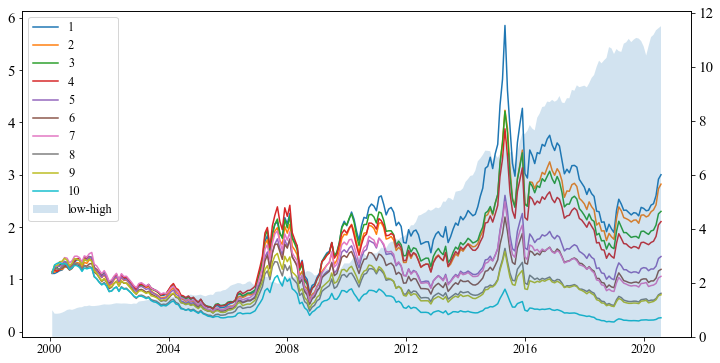

In [102]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'# 中文设置成宋体，除此之外的字体设置成New Roman 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=12.5)

def cumret(factor):
    return (factor+1).cumprod()
quantile = q_size

fig,ax1 = plt.subplots(figsize=(12,6))
l1 = ax1.plot(dt,cumret(port_result[[str(i) for i in range(quantile)]]))
ax2 = ax1.twinx()
l2 = ax2.stackplot(dt,cumret(port_result['high-low']),alpha=0.2)
#l1 = ax1.plot(dt,port_result[[str(i) for i in range(quantile)]].cumsum())
#l2 = ax2.stackplot(dt,port_result['high-low'].cumprod(),alpha=0.2)
plt.legend(l1+l2, [str(i+1) for i in range(quantile)] + ['low-high'],loc='upper left',fontsize=12.5)

# 计算回测指标

## 计算基本指标

In [103]:
result = pd.DataFrame()
result['port_mean_ret'] = 12*port_result.mean().reset_index(drop=True) # 因子组合年度收益率
result['t-stats'] = stats.ttest_1samp(port_result,0).statistic # t统计量
result['port_annual_vol'] = math.sqrt(12)*port_result.std().reset_index(drop=True) # 因子组合年化波动率
result['sharpe_ratio'] = result['port_mean_ret']/result['port_annual_vol'] # 因子组合夏普比率
result['Maxdraw'] = (port_result.expanding().max() - port_result).max().tolist() # 因子组合最大回撤
result = result.T
result.columns = port_result.columns

In [104]:
# 好看的显示格式
result.T.style.applymap(lambda x: 'color:red' if abs(x)>2 else 'color:None',subset='t-stats').\
        applymap(lambda x: 'background-color:lime' if x>0.6 else 'background-color:None',subset='Maxdraw').\
        applymap(lambda x: 'background-color:red' if x>0.5 else 'background-color:None',subset='sharpe_ratio')

,port_mean_ret,t-stats,port_annual_vol,sharpe_ratio,Maxdraw
0,0.103477,1.484735,0.316193,0.327259,0.597139
1,0.103338,1.443790,0.324725,0.318234,0.584483
2,0.091671,1.298651,0.320258,0.286243,0.605813
3,0.088916,1.243299,0.324460,0.274042,0.607500
4,0.068861,0.975671,0.320203,0.215053,0.576692
5,0.059570,0.845136,0.319785,0.186281,0.585976
6,0.054148,0.767330,0.320156,0.169132,0.591479
7,0.033634,0.488143,0.312598,0.107594,0.574314
8,0.031133,0.456629,0.309321,0.100648,0.546809
9,-0.019983,-0.305325,0.296929,-0.067298,0.539899


## 计算risk-adjusted $\alpha$

In [105]:
# data source: https://www.factorwar.com/data/factor-models/
capm = pd.read_csv('../benchmark_factor/capm_factor.csv')
ff3 = pd.read_csv('../benchmark_factor/ff3_factor.csv')
carhart = pd.read_csv('../benchmark_factor/carhart_factor.csv')
ff5 = pd.read_csv('../benchmark_factor/ff5_factor.csv')
q = pd.read_csv('../benchmark_factor/q_factor.csv')
sy = pd.read_csv('../benchmark_factor/sy_factor.csv')
dhs = pd.read_csv('../benchmark_factor/dhs_factor.csv')

capm['month'] = capm['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
ff3['month'] = ff3['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
carhart['month'] = carhart['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
ff5['month'] = ff5['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
q['month'] = q['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
sy['month'] = sy['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)
dhs['month'] = dhs['date'].apply(lambda x: x.split('-')[0]+x.split('-')[1]).astype(int)

reg_capm = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),capm).dropna().reset_index(drop=True)
reg_ff3 = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),ff3).dropna().reset_index(drop=True)
reg_carhart = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),carhart).dropna().reset_index(drop=True)
reg_ff5 = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),ff5).dropna().reset_index(drop=True)
reg_q = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),q).dropna().reset_index(drop=True)
reg_sy = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),sy).dropna().reset_index(drop=True)
reg_dhs = pd.merge(port_result.reset_index().rename(columns={'index':'month'}),dhs).dropna().reset_index(drop=True)

reg_all = pd.merge(reg_ff5,reg_carhart[['month','UMD']],on='month')
reg_all = pd.merge(reg_all,reg_q[['month','R_inv','R_roe']],on='month')
reg_all = pd.merge(reg_all,reg_sy[['month','R_mgmt','R_perf']],on='month')
reg_all = pd.merge(reg_all,reg_dhs[['month','R_fin','R_pead']],on='month').reset_index(drop=True)

In [106]:
def outreg1(y,x):
    X = sm.add_constant(x)
    # Newey-West t, lag = N^(1/4) = 220^(1/4) = 4
    result = sm.OLS(y,X).fit(cov_type='HAC',cov_kwds={'maxlags':4})
    coef = result.params.values
    tvalue = result.tvalues.values
    coef_name = result.params.index.to_numpy()
    coef_t_name = list(map(lambda x:x+'_t',coef_name))
    output = pd.DataFrame()
    output['coef'] = coef
    output['tvalue'] = tvalue
    output.index = coef_name
    output.loc['N'] = round(result.nobs,0)
    output.loc['R2'] = result.rsquared_adj
    return output

In [107]:
y_idx = 'high-low'
regtab = pd.DataFrame(index=['const','MKT','SMB','HML','RMW','CMA',\
                             'UMD','R_me','R_inv', 'R_roe','R_smb',\
                             'R_mgmt','R_perf','R_fin','R_pead','N','R2'])
x = reg_ff5[['MKT','SMB','HML','RMW','CMA']]
y = reg_ff5[y_idx]
regtab[['FF5','FF5_t']] = outreg1(y,x)

x = reg_carhart[['MKT','SMB','HML','UMD']]
y = reg_carhart[y_idx]
regtab[['Carhart','Carhart_t']] = outreg1(y,x)

x = reg_q[['MKT','R_me','R_inv','R_roe']]
y = reg_q[y_idx]
regtab[['HXZ4','HXZ_t']] = outreg1(y,x)

x = reg_sy[['MKT','R_smb','R_mgmt','R_perf']]
y = reg_sy[y_idx]
regtab[['SY4','SY_t']] = outreg1(y,x)

x = reg_dhs[['MKT','R_fin','R_pead']]
y = reg_dhs[y_idx]
regtab[['DHS4','DHS4_t']] = outreg1(y,x)

x = reg_all[['MKT','SMB','HML','RMW','CMA','UMD','R_inv','R_roe','R_mgmt','R_perf','R_fin','R_pead']]
y = reg_all[y_idx]
regtab[['ALL','ALL_t']] = outreg1(y,x)
# x = reg_ff3[['MKT','SMB','HML']]
# y = reg_ff3[y_idx]
# x = reg_capm[['MKT']]
# y = reg_capm[y_idx]
regtab = regtab.T.rename(columns={'const':'Alpha'})
regtab

,Alpha,MKT,SMB,HML,RMW,CMA,UMD,R_me,R_inv,R_roe,R_smb,R_mgmt,R_perf,R_fin,R_pead,N,R2
FF5,0.008742,0.013855,0.240294,0.020373,0.042676,-0.011883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0,0.124361
FF5_t,5.071134,0.706383,3.779585,0.350561,0.436148,-0.079666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0,0.124361
Carhart,0.009158,0.007489,0.212891,0.004211,NaN,NaN,0.050537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0,0.128110
Carhart_t,6.007914,0.413887,5.160379,0.072582,NaN,NaN,1.108779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0,0.128110
HXZ4,0.009131,0.004576,NaN,NaN,NaN,NaN,NaN,0.244102,0.031222,-0.057813,NaN,NaN,NaN,NaN,NaN,203.0,0.197329
HXZ_t,5.502525,0.246840,NaN,NaN,NaN,NaN,NaN,4.866821,0.339357,-0.932442,NaN,NaN,NaN,NaN,NaN,203.0,0.197329
SY4,0.007939,0.030542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242618,0.187532,0.114523,NaN,NaN,220.0,0.198311
SY_t,5.089947,1.447096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.227880,2.376034,2.606455,NaN,NaN,220.0,0.198311
DHS4,0.010778,0.015000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027917,-0.185590,220.0,0.017279
DHS4_t,6.383869,0.529078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.294733,-1.545731,220.0,0.017279


# 因子组合分析 (double sort)

In [145]:
def qcut2(rebalance_group,fac_name,q_size):
    rebalance_group = rebalance_group[rebalance_group[fac_name]>=rebalance_group[fac_name].quantile(q=0.1)].reset_index(drop=True)
    rebalance_group = rebalance_group.sort_values(by=fac_name).reset_index(drop=True)
    rebalance_group['decile2'] = pd.qcut(rebalance_group.index,q = q_size,labels = [str(i) for i in range(q_size)])
    return rebalance_group

In [108]:
month_list = total['month'].unique().tolist()
q_size = 5
fac_name1 = 'skew'
fac_name2 = 'total_mv'
Mret_list = []
Rf = rf.groupby('month').apply(lambda x:x.iloc[-1]).reset_index(drop=True)[['month','R007']]

for i in range(1,len(month_list)):
    rebalance_group = total[total['month'] == month_list[i-1]].reset_index(drop=True)
    rebalance_group['decile1'] = pd.qcut(rebalance_group[fac_name1],q=q_size,labels = [str(i) for i in range(q_size)])
    #rebalance_group = qcut2(rebalance_group,fac_name2,q_size)
    rebalance_group['decile2'] = pd.qcut(rebalance_group[fac_name2],q=q_size,labels = [str(i) for i in range(q_size)])
    rebalance_group['decile'] = rebalance_group['decile1'].astype(str)+rebalance_group['decile2'].astype(str)

    current_group = total[total['month'] == month_list[i]].reset_index(drop=True)
    current_group = current_group.rename(columns={'total_mv':'total_mv_end'}) # 获得月初的总市值
    current_group = pd.merge(current_group,rebalance_group[['ts_code','decile','total_mv']]) # 结合上一句，用来计算VW_ret
    current_group = current_group[pd.notnull(current_group['decile'])].reset_index(drop=True)
    current_group['vw_ret'] = current_group['total_mv']*current_group['pct_chg']

    rf_rate = Rf[Rf['month']==month_list[i]]['R007'].iloc[0]*12
    # EW return
    group_ret = current_group.groupby('decile').mean()['pct_chg'] - rf_rate
    # VW return
    #group_ret = current_group.groupby('decile').sum()['vw_ret']/current_group.groupby('decile').sum()['total_mv'] - rf_rate
    group_ret.name = month_list[i]

    Mret_list.append(group_ret)

In [109]:
port_result = pd.concat(Mret_list,axis=1).T
port_result = pd.DataFrame(port_result.values,index=port_result.index,columns=port_result.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result.index.tolist()))
port_result['high-low'] = (port_result['00']+port_result['01']+port_result['02']+port_result['03']+port_result['04'])/q_size \
                           - (port_result['40']+port_result['41']+port_result['42']+port_result['43']+port_result['44'])/q_size

In [110]:
#ttest = stats.ttest_1samp(port_result,0)
ttest = [stats.ttest_1samp(port_result.iloc[:,i].dropna().reset_index(drop=True),0).statistic for i in range(26)]
result = pd.DataFrame()
result['port_mean_ret'] = 100*port_result.mean().reset_index(drop=True) # 因子组合年度收益率
result['t-stats'] = ttest # t统计量
result['port_annual_vol'] = math.sqrt(12)*port_result.std().reset_index(drop=True) # 因子组合年化波动率
result['sharpe_ratio'] = result['port_mean_ret']/result['port_annual_vol']/100*12 # 因子组合夏普比率
result['Maxdraw'] = (port_result.expanding().max() - port_result).max().tolist() # 因子组合最大回撤
result = result.T
result.columns = port_result.columns

In [114]:
# 好看的显示格式
result.T.style.applymap(lambda x: 'color:red' if abs(x)>2 else 'color:None',subset='t-stats').\
        applymap(lambda x: 'background-color:lime' if x>0.6 else 'background-color:None',subset='Maxdraw').\
        applymap(lambda x: 'background-color:red' if x>0.5 else 'background-color:None',subset='sharpe_ratio')

,port_mean_ret,t-stats,port_annual_vol,sharpe_ratio,Maxdraw
00,1.761733,2.710809,0.353818,0.597504,0.586917
01,0.878740,1.410267,0.339233,0.310845,0.621490
02,0.645153,1.076110,0.326396,0.237191,0.602154
03,0.427390,0.753263,0.308899,0.166031,0.564279
04,0.224992,0.426730,0.287047,0.094058,0.575679
10,1.695352,2.627278,0.351312,0.579093,0.597303
11,0.926301,1.487807,0.338957,0.327936,0.647383
12,0.473103,0.773564,0.332965,0.170506,0.636015
13,0.352428,0.603815,0.317764,0.133090,0.602166
14,0.202987,0.373803,0.295641,0.082392,0.550521


In [115]:
coef = list(result.T['port_mean_ret'].iloc[0:-1].values.reshape(5,5).T)
tvalue = list(result.T['t-stats'].iloc[0:-1].values.reshape(5,5).T)
double_sort_result = pd.DataFrame(np.vstack([np.vstack([a,b]) for a,b in zip(coef,tvalue)]))
hs_sub_ls = pd.DataFrame()
hs_sub_ls[0] = (port_result['00'] - port_result['40'])
hs_sub_ls[1] = (port_result['01'] - port_result['41'])
hs_sub_ls[2] = (port_result['02'] - port_result['42'])
hs_sub_ls[3] = (port_result['03'] - port_result['43'])
hs_sub_ls[4] = (port_result['04'] - port_result['44'])
tstat_hs_sub_ls = stats.ttest_1samp(hs_sub_ls.dropna().reset_index(drop=True),0).statistic
double_sort_result['hs-ls']=pd.DataFrame(np.vstack([100*hs_sub_ls.mean().to_numpy(),tstat_hs_sub_ls]).T.reshape(q_size*2,1))

hm_sub_lm = pd.DataFrame()
hm_sub_lm[0] = (port_result['00'] - port_result['04'])
hm_sub_lm[1] = (port_result['10'] - port_result['14'])
hm_sub_lm[2] = (port_result['20'] - port_result['24'])
hm_sub_lm[3] = (port_result['30'] - port_result['34'])
hm_sub_lm[4] = (port_result['40'] - port_result['44'])
# hm_sub_lm[5] = (port_result['00']+port_result['01']+port_result['02']+port_result['03']+port_result['04'])/q_size \
#                            - (port_result['40']+port_result['41']+port_result['42']+port_result['43']+port_result['44'])/q_size
hm_sub_lm[5] = (port_result['00']+port_result['10']+port_result['20']+port_result['30']+port_result['40'])/q_size \
                            - (port_result['04']+port_result['14']+port_result['24']+port_result['34']+port_result['44'])/q_size

tstat_hm_sub_lm = stats.ttest_1samp(hm_sub_lm.dropna().reset_index(drop=True),0).statistic
double_sort_result.loc['hm-lm'] = hm_sub_lm.mean().values*100
double_sort_result.loc['hm-lm_t'] = tstat_hm_sub_lm
double_sort_result

,0,1,2,3,4,hs-ls
0,1.761733,1.695352,1.441112,1.082142,0.819068,0.942666
1,2.710809,2.627278,2.186210,1.669182,1.279584,6.885840
2,0.878740,0.926301,0.754909,0.414258,0.218923,0.659817
3,1.410267,1.487807,1.207577,0.667422,0.360948,3.817298
4,0.645153,0.473103,0.400473,0.303628,-0.136699,0.781851
5,1.076110,0.773564,0.649136,0.504087,-0.233111,4.235044
6,0.427390,0.352428,0.133431,0.058333,-0.275553,0.702943
7,0.753263,0.603815,0.230592,0.100460,-0.502772,3.810670
8,0.224992,0.202987,0.000770,0.004195,-0.138251,0.363243
9,0.426730,0.373803,0.001452,0.007779,-0.265169,2.011211


In [157]:
1.49*12

17.88

# Fama-Macbeth回归

## 简化版本

In [4]:
def outreg(var_list):
    # cross-sectional regressiono
    lambda_list = []
    R_list = []
    N_list = []
    month_list = total['month'].unique().tolist()
    for i in range(1,len(month_list)):
        group_l1 = total[total['month'] == month_list[i-1]].reset_index(drop=True)
        group_l1['lnpe'] = np.log(group_l1['pe'])
        group_l1['lnpb'] = np.log(group_l1['pb'])
        group_l1['lnmv'] = np.log(group_l1['total_mv'])
        #group_l1['co_prod'] = group_l1['coskew']*group_l1['cokurt']
        group_l1 = group_l1.rename(columns={'pct_chg':'ret_l1'})
        group = total[total['month']==month_list[i]].reset_index(drop=True)
        reg_df = pd.merge(group[['ts_code','pct_chg']],group_l1,on=['ts_code']).dropna().reset_index(drop=True)
        #control_x = ['lnpe','lnpb','lnmv']
        x = reg_df[var_list]
        X = sm.add_constant(x)
        y = reg_df['pct_chg']
        result = sm.OLS(y,X).fit() # 因为是截面回归所以不做HAC调整（做了调整结果也类似）
        dic1 = {
            'month':month_list[i]
        }
        dic = {**dic1,**result.params}
        lambda_list.append(dic)
        R_list.append(result.rsquared_adj)
        N_list.append(result.nobs)
    lambda_df = pd.DataFrame(lambda_list)
    # tabulate
    coef = lambda_df.iloc[:,1:].mean().values
    tvalue = stats.ttest_1samp(lambda_df.iloc[:,1:],0).statistic

    coef_name = lambda_df.iloc[:,1:].mean().index.tolist()
    coef_t_name = list(map(lambda x:x+'_t',coef_name))
    output = pd.DataFrame(np.vstack([coef,tvalue]).T.reshape(len(coef_name)*2,1))
    output.index = np.vstack([coef_name,coef_t_name]).T.reshape(len(coef_name)*2,1).T.tolist()[0]
    output.loc['N'] = sum(N_list)
    output.loc['Adj_R2'] = np.mean(R_list)*100
    return output # 返回回归系数和t值的Series object

In [5]:
example = outreg(['skew','Max3d'])
example

,0
const,0.017335
const_t,3.117393
skew,-0.001559
skew_t,-1.953601
Max3d,-0.269038
Max3d_t,-4.908846
N,365933.000000
Adj_R2,2.237339


In [11]:
#fmbtab = pd.DataFrame(index = ['const','const_t','skew','skew_t','coskew','coskew_t','Max1d','Max1d_t','Max5d','Max5d_t','Max7d','Max7d_t','lnpe','lnpe_t','lnpb','lnpb_t','lnmv','lnmv_t','N','R2'])
# fmbtab = pd.DataFrame(index = ['const','const_t','skew','skew_t','Max3d','Max3d_t','Max5d','Max5d_t','Max7d','Max7d_t','lnpe','lnpe_t','lnpb','lnpb_t','lnmv','lnmv_t','N','Adj_R2'])
# control_x = ['lnpe','lnpb','lnmv']
# fmbtab[1] = outreg(['skew']+control_x)
# fmbtab[2] = outreg(['Max5d']+control_x)
# fmbtab[3] = outreg(['Max7d']+control_x)
# fmbtab[4] = outreg(['skew','Max3d']+control_x)
# fmbtab[5] = outreg(['skew','Max5d']+control_x)
# fmbtab[6] = outreg(['skew','Max7d']+control_x)
# fmbtab
fmbtab = pd.DataFrame(index = ['const','const_t','iskew','iskew_t','Max3d','Max3d_t','Max5d','Max5d_t','Max7d','Max7d_t','lnpe','lnpe_t','lnpb','lnpb_t','lnmv','lnmv_t','N','Adj_R2'])
control_x = ['lnpe','lnpb','lnmv']
fmbtab[1] = outreg(['iskew']+control_x)
fmbtab[2] = outreg(['Max5d']+control_x)
fmbtab[3] = outreg(['Max7d']+control_x)
fmbtab[4] = outreg(['iskew','Max3d']+control_x)
fmbtab[5] = outreg(['iskew','Max5d']+control_x)
fmbtab[6] = outreg(['iskew','Max7d']+control_x)
fmbtab

,1,2,3,4,5,6
const,0.077741,0.087197,0.088116,0.084059,0.084435,0.085384
const_t,4.271944,4.788519,4.829117,4.655752,4.677506,4.718714
iskew,-0.002520,NaN,NaN,-0.001112,-0.001438,-0.001611
iskew_t,-6.317995,NaN,NaN,-2.370965,-3.319954,-3.877444
Max3d,NaN,NaN,NaN,-0.285782,NaN,NaN
Max3d_t,NaN,NaN,NaN,-6.632623,NaN,NaN
Max5d,NaN,-0.391836,NaN,NaN,-0.357586,NaN
Max5d_t,NaN,-7.815550,NaN,NaN,-6.741200,NaN
Max7d,NaN,NaN,-0.469283,NaN,NaN,-0.427450
Max7d_t,NaN,NaN,-7.754364,NaN,NaN,-6.769636


## 严格版本 (似乎不对...)

In [93]:
#control_x = ['MKT']
#control_x = ['MKT','SMB','HML']
#control_x = ['MKT','SMB','HML','UMD']
control_x = ['MKT','R_me','R_inv','R_roe']
#control_x = ['MKT','SMB','HML','RMW','CMA']
bench_model = q

### 时间序列回归估计$\beta_i$

In [94]:
port_result_reg = port_result.reset_index().rename(columns={'index':'month'})[['month','high-low']]
beta_list = []
for code,group in stk_month.groupby('ts_code'):
    ts_reg_df = pd.merge(group[['month','pct_chg']],bench_model[['month']+control_x])
    ts_reg_df = pd.merge(ts_reg_df,port_result_reg).dropna().reset_index(drop=True)
    if len(ts_reg_df)>10:
        x = ts_reg_df[control_x+['high-low']]
        X = sm.add_constant(x)
        y = ts_reg_df['pct_chg']
        result = sm.OLS(y,X).fit(cov_type='HAC',cov_kwds={'maxlags':4})
        dic1 = {
            "ts_code":code,
            "t":result.tvalues['high-low'],
            "obs":result.nobs
        }
        dic = {**dic1,**result.params.to_dict()}
        beta_list.append(dic)
    else:
        pass
beta_df = pd.DataFrame(beta_list)

### 截面回归估计$\lambda_i$

In [95]:
lambda_list = []
for month,group in stk_month.groupby('month'):
    cross_reg_df = pd.merge(group[['ts_code','pct_chg']],beta_df[['ts_code','high-low']+control_x])
    x = cross_reg_df[['high-low']+control_x]
    X = sm.add_constant(x)
    y = cross_reg_df['pct_chg']
    result = sm.OLS(y,X).fit()
    dic1 = {
        'month':month
    }
    dic = {**dic1,**result.params}
    lambda_list.append(dic)
lambda_df = pd.DataFrame(lambda_list)

### 估计因子风险溢酬并计算标准误

In [96]:
def calculate_standard_error(series):
    return np.sqrt(
            np.power(
                (series-series.mean()),2
            ).sum() / (len(series)**2)
    )

risk_premium_df = pd.DataFrame()
risk_premium_df['risk_premium'] = lambda_df.mean()
risk_premium_df['standard_error'] = calculate_standard_error(lambda_df)
risk_premium_df['t-stats'] = risk_premium_df['risk_premium']/risk_premium_df['standard_error']
risk_premium_df = risk_premium_df.drop(index='month')

In [97]:
risk_premium_df.style.applymap(lambda x:"color:red" if abs(x)>1.8 else "color:None",subset='t-stats')

,risk_premium,standard_error,t-stats
const,-0.002569,0.004364,-0.588744
high-low,-0.001488,0.002863,-0.519681
MKT,0.009171,0.006028,1.521320
R_me,0.000573,0.002745,0.208637
R_inv,-0.000476,0.001550,-0.307113
R_roe,0.001857,0.002375,0.781643


In [98]:
stats.ttest_1samp(lambda_df[['const','high-low']+control_x],0)

Ttest_1sampResult(statistic=array([-0.58757449, -0.51864905,  1.51829849,  0.20822305, -0.30650276,
        0.78009027]), pvalue=array([0.55734615, 0.60446243, 0.1301977 , 0.83522367, 0.75947598,
       0.43607273]))

# 附录：因子收益率描述性统计

In [145]:
month_list = total['month'].unique().tolist()
q_size = 10
fac_name = 'Max7d' # or 'coskew'
Mret_list = []
Rf = rf.groupby('month').apply(lambda x:x.iloc[-1]).reset_index(drop=True)[['month','R007']]

for i in range(1,len(month_list)):
    rebalance_group = total[total['month'] == month_list[i-1]].reset_index(drop=True)
    # 偏度指标分组
    #rebalance_group['decile'] = pd.qcut(rebalance_group[fac_name],q=q_size,labels = [str(i) for i in range(q_size)])
    # 最大日收益指标分组（只是为了避免报错。。。）
    rebalance_group = qcut(rebalance_group,fac_name,q_size)
    
    current_group = total[total['month'] == month_list[i]].reset_index(drop=True)
    current_group = current_group.rename(columns={'total_mv':'total_mv_end'})
    current_group = pd.merge(current_group,rebalance_group[['ts_code','decile','total_mv']])
    current_group = current_group[pd.notnull(current_group['decile'])].reset_index(drop=True)
    current_group['vw_ret'] = current_group['total_mv']*current_group['pct_chg']
    
    rf_rate = Rf[Rf['month']==month_list[i]]['R007'].iloc[0]*12
    # EW return
    group_ret = current_group.groupby('decile').mean()['pct_chg'] - rf_rate
    # VW return
    #group_ret = current_group.groupby('decile').sum()['vw_ret']/current_group.groupby('decile').sum()['total_mv'] - rf_rate
    group_ret.name = month_list[i]
    
    Mret_list.append(group_ret)

In [136]:
# skew
port_result1 = pd.concat(Mret_list,axis=1).T
port_result1 = pd.DataFrame(port_result1.values,index=port_result1.index,columns=port_result1.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result1.index.tolist()))
port_result1['high-low'] = -(port_result1[str(q_size-1)] - port_result1['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [138]:
# coskew
port_result2 = pd.concat(Mret_list,axis=1).T
port_result2 = pd.DataFrame(port_result2.values,index=port_result2.index,columns=port_result2.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result2.index.tolist()))
port_result2['high-low'] = -(port_result2[str(q_size-1)] - port_result2['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [140]:
# iskew
port_result3 = pd.concat(Mret_list,axis=1).T
port_result3 = pd.DataFrame(port_result3.values,index=port_result3.index,columns=port_result3.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result3.index.tolist()))
port_result3['high-low'] = -(port_result3[str(q_size-1)] - port_result3['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [142]:
# Max3d
port_result4 = pd.concat(Mret_list,axis=1).T
port_result4 = pd.DataFrame(port_result4.values,index=port_result4.index,columns=port_result4.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result4.index.tolist()))
port_result4['high-low'] = -(port_result4[str(q_size-1)] - port_result4['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [144]:
# Max5d
port_result5 = pd.concat(Mret_list,axis=1).T
port_result5 = pd.DataFrame(port_result5.values,index=port_result5.index,columns=port_result5.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result5.index.tolist()))
port_result5['high-low'] = -(port_result5[str(q_size-1)] - port_result5['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [146]:
# Max7d
port_result6 = pd.concat(Mret_list,axis=1).T
port_result6 = pd.DataFrame(port_result6.values,index=port_result6.index,columns=port_result6.columns.tolist())
dt = list(map(lambda x:datetime.strptime(str(x),'%Y%m'),port_result6.index.tolist()))
port_result6['high-low'] = -(port_result6[str(q_size-1)] - port_result6['0']) # (port_result[str(q_size-1)] - port_result['0']) if fac_name == 'coskew' 

In [148]:
pd.concat(
    [
        port_result1.rename(columns={'high-low':'skew'})['skew'].describe(),
        port_result2.rename(columns={'high-low':'coskew'})['coskew'].describe(),
        port_result3.rename(columns={'high-low':'iskew'})['iskew'].describe(),
        port_result4.rename(columns={'high-low':'Max3d'})['Max3d'].describe(),
        port_result5.rename(columns={'high-low':'Max5d'})['Max5d'].describe(),
        port_result6.rename(columns={'high-low':'Max7d'})['Max7d'].describe(),
        capm['MKT'].describe(),
        ff5['SMB'].describe(),
        ff5['HML'].describe(),
        ff5['RMW'].describe(),
        ff5['CMA'].describe(),
        carhart['UMD'].describe(),
        q['R_inv'].describe(),
        q['R_roe'].describe(),
        sy['R_mgmt'].describe(),
        sy['R_perf'].describe(),
        dhs['R_fin'].describe(),
        dhs['R_pead'].describe()
    ],axis=1
)


,skew,coskew,iskew,Max3d,Max5d,Max7d,MKT,SMB,HML,RMW,CMA,UMD,R_inv,R_roe,R_mgmt,R_perf,R_fin,R_pead
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,207.000000,207.000000,225.000000,225.000000,224.000000,224.000000
mean,0.010288,0.002591,0.007417,0.019034,0.019085,0.018859,0.011354,0.006185,0.004454,0.002517,-0.002414,0.000215,0.000223,0.007064,-0.000136,0.005668,0.003055,0.002203
std,0.026499,0.032198,0.027099,0.039850,0.041736,0.040901,0.082236,0.046563,0.046481,0.039729,0.027862,0.042905,0.020484,0.035802,0.032166,0.045330,0.027047,0.020572
min,-0.129661,-0.172038,-0.172556,-0.090788,-0.102675,-0.102228,-0.249598,-0.231450,-0.175990,-0.154054,-0.128406,-0.134186,-0.086705,-0.116880,-0.149962,-0.172100,-0.094044,-0.070656
25%,-0.004254,-0.014578,-0.002700,-0.003464,-0.004811,-0.004662,-0.043215,-0.020905,-0.016397,-0.015903,-0.016685,-0.023346,-0.011214,-0.013640,-0.019894,-0.019612,-0.011958,-0.006430
50%,0.010432,0.002431,0.007158,0.017214,0.018236,0.017196,0.008384,0.005840,0.003133,0.000307,-0.001785,0.001161,-0.001394,0.007579,0.002601,0.007930,0.002552,0.002775
75%,0.024126,0.019318,0.021541,0.041189,0.039248,0.040765,0.053270,0.031023,0.025512,0.022823,0.012161,0.025375,0.012144,0.027235,0.016167,0.032860,0.018459,0.014738
max,0.083061,0.091094,0.077916,0.155145,0.185141,0.193208,0.333979,0.203644,0.281128,0.178450,0.142250,0.136714,0.057459,0.126140,0.166101,0.138253,0.088788,0.063997


In [149]:
factor_df = pd.concat([
    port_result1.rename(columns={'high-low':'skew'})[['skew']],
    port_result2.rename(columns={'high-low':'coskew'})['coskew'],
    port_result3.rename(columns={'high-low':'iskew'})['iskew'],
    port_result4.rename(columns={'high-low':'Max3d'})['Max3d'],
    port_result5.rename(columns={'high-low':'Max5d'})['Max5d'],
    port_result6.rename(columns={'high-low':'Max7d'})['Max7d']
],axis=1).reset_index().rename(columns={'index':'month'})

In [150]:
reg_all = pd.merge(factor_df,reg_ff5[['month','MKT','SMB','HML','RMW','CMA']],on='month')
reg_all = pd.merge(reg_all,reg_carhart[['month','UMD']],on='month')
reg_all = pd.merge(reg_all,reg_q[['month','R_inv','R_roe']],on='month')
reg_all = pd.merge(reg_all,reg_sy[['month','R_mgmt','R_perf']],on='month')
reg_all = pd.merge(reg_all,reg_dhs[['month','R_fin','R_pead']],on='month').reset_index(drop=True)

In [151]:
reg_all.iloc[:,1:].corr()

,skew,coskew,iskew,Max3d,Max5d,Max7d,MKT,SMB,HML,RMW,CMA,UMD,R_inv,R_roe,R_mgmt,R_perf,R_fin,R_pead
skew,1.000000,0.385427,0.604470,0.018467,-0.010922,-0.024426,0.080119,0.430632,-0.194047,-0.312314,0.163063,-0.073962,0.015407,-0.319369,-0.183584,0.094102,-0.064588,-0.189496
coskew,0.385427,1.000000,-0.021938,0.188069,0.196346,0.174434,-0.051431,0.362708,-0.182584,-0.229830,0.144381,-0.025403,0.084825,-0.193659,-0.102865,0.080524,-0.071263,-0.135803
iskew,0.604470,-0.021938,1.000000,-0.186674,-0.215597,-0.216649,-0.031412,0.263553,-0.294913,-0.107882,-0.038672,0.219433,-0.116699,-0.102279,-0.280591,0.342258,-0.054719,-0.003507
Max3d,0.018467,0.188069,-0.186674,1.000000,0.966603,0.949322,-0.149126,-0.049887,0.311384,0.055430,0.234444,-0.198629,0.252283,0.025479,0.365398,-0.221817,0.154604,0.117211
Max5d,-0.010922,0.196346,-0.215597,0.966603,1.000000,0.981125,-0.160882,-0.032282,0.320818,0.035991,0.259975,-0.229372,0.276377,0.004513,0.386083,-0.261470,0.198987,0.096433
Max7d,-0.024426,0.174434,-0.216649,0.949322,0.981125,1.000000,-0.150586,-0.047220,0.300905,0.065830,0.238327,-0.191747,0.259130,0.044496,0.362247,-0.223108,0.185318,0.094951
MKT,0.080119,-0.051431,-0.031412,-0.149126,-0.160882,-0.150586,1.000000,0.112900,0.023087,-0.343683,0.043544,-0.077680,-0.008628,-0.282349,-0.222507,-0.095168,-0.161729,-0.308629
SMB,0.430632,0.362708,0.263553,-0.049887,-0.032282,-0.047220,0.112900,1.000000,-0.457767,-0.723381,0.274081,-0.242818,0.009661,-0.684236,-0.520795,0.000228,-0.379296,-0.396689
HML,-0.194047,-0.182584,-0.294913,0.311384,0.320818,0.300905,0.023087,-0.457767,1.000000,0.071600,0.474137,-0.277065,0.596738,0.058134,0.797848,-0.494667,0.422835,0.114301
RMW,-0.312314,-0.229830,-0.107882,0.055430,0.035991,0.065830,-0.343683,-0.723381,0.071600,1.000000,-0.586970,0.437758,-0.327383,0.860850,0.238037,0.317284,0.232077,0.460220


In [119]:
codes = total['ts_code'].unique().tolist()[0:50]
total[total['ts_code'].isin(codes)].reset_index(drop=True).to_excel('c://users//coolgan//desktop//total_cleaned_demo.xlsx',index=False)